# Load dependencies
- Change oversample indices

In [1]:
import os
os.getcwd()
os.chdir('/tf/notebooks/ruez/stroke_bern')

In [2]:
!pip install tabulate

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# from PIL import Image
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
# from scipy import ndimage
from scipy import ndimage
from scipy.special import expit, logit

from skimage import exposure
import sklearn.metrics as skm
from tabulate import tabulate

# Tensorflow/Keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
print(tf.__version__) #2.4.0
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.utils import to_categorical
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Own functions
from functions.plot_slices import plot_slices
from functions.CNN_architecture import Conv2Plus1D
from functions.keras_training_progress import PlotLearning
# ontram functions
from k_ontram_functions.ontram import ontram
from k_ontram_functions.ontram_loss import ontram_loss
from k_ontram_functions.ontram_metrics import ontram_acc, ontram_auc
from k_ontram_functions.ontram_predict import predict_ontram, get_parameters

from functions.augmentation3d import zoom, rotate, flip, shift

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-7hgopou7 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


2.4.0


In [4]:
# Define the path + output path:
# os.getcwd()
DIR = "/tf/notebooks/"
DATA_DIR = "ruez/stroke_bern/data/"
OUTPUT_DIR = "/tf/notebooks/ruez/stroke_bern/callbacks/ontrams_3d_clinical_dwi_cause/"

# Import images

In [5]:
with h5py.File(DIR + DATA_DIR + "data_bern_25_11_2020_preprocessed.h5", "r") as h5:
    X0 = h5["X_dwi"][:]
print(X0.shape, X0.min(), X0.max(), X0.mean(), X0.std()) # patients, coronal, sagittal, axial, channels

(222, 128, 128, 64, 1) -7.217837989522173 39.758812613731685 -3.158197493145928 1.8809703357091876


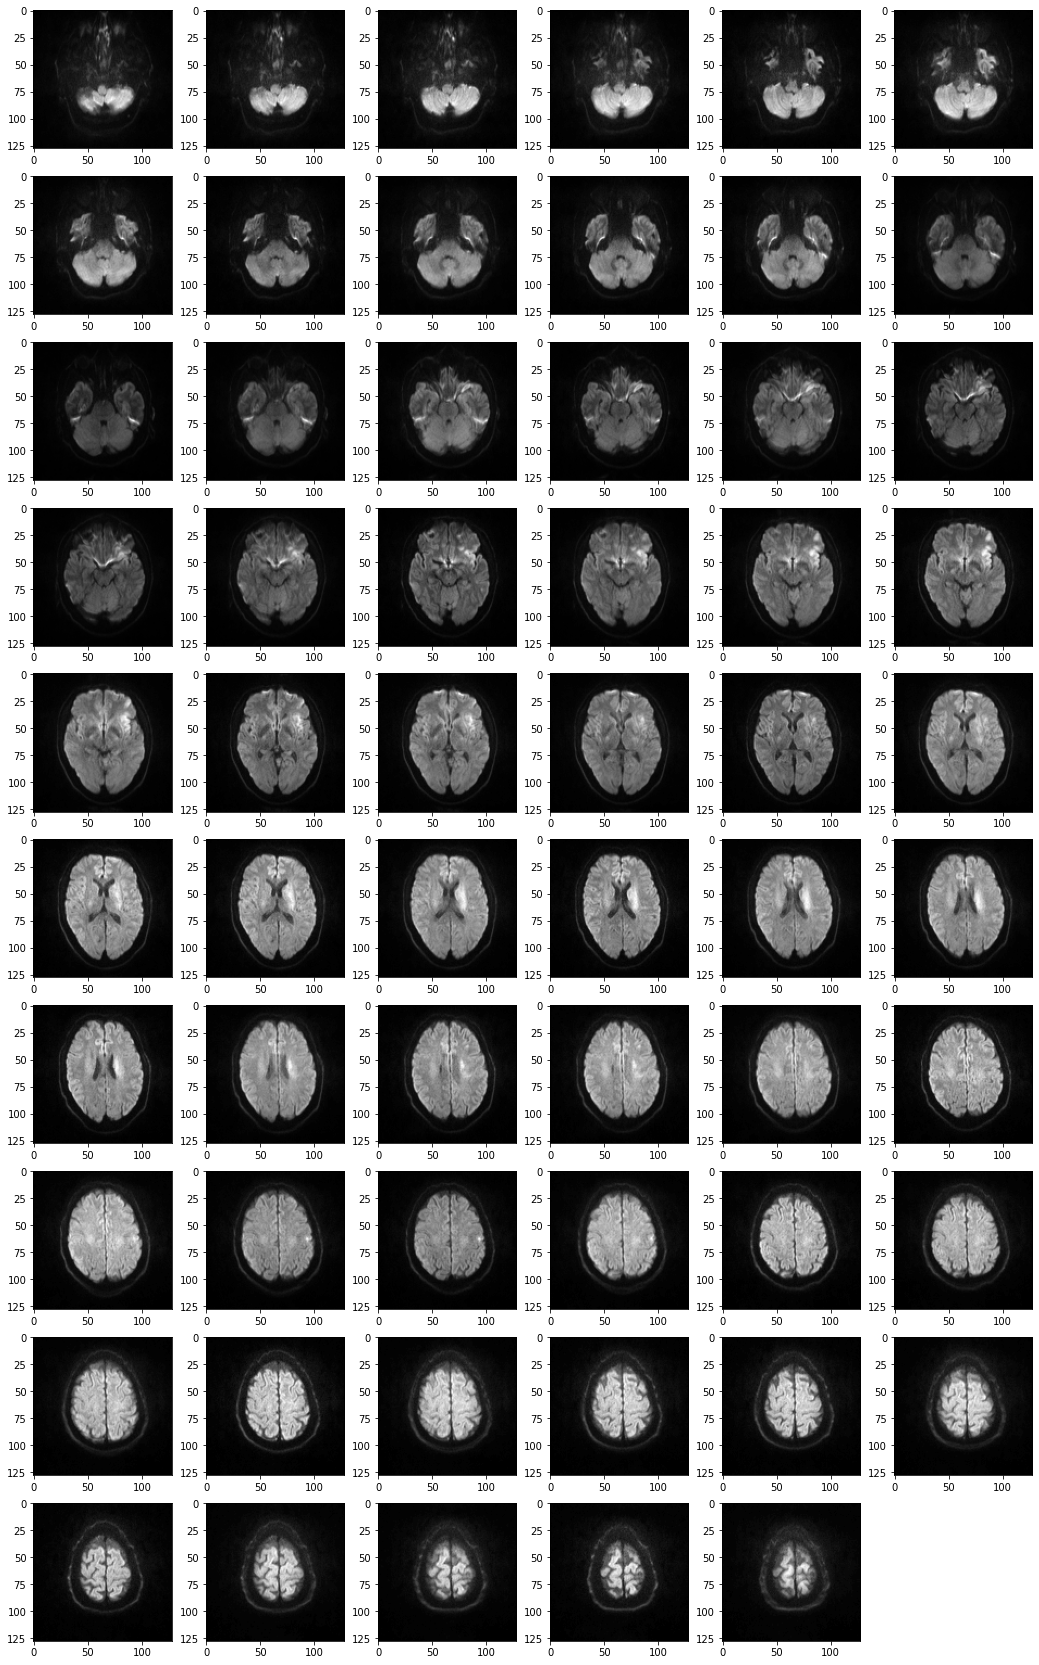

In [7]:
plot_slices(X0[31], 0, "axial", modality = "DWI") # e.g. patient with toast 1 (microangiopathie)

#### Reduce images per patient

In [6]:
# Reshape the data to reduce images per patient
print('old shape: ', X0[0].shape[:]) # original shape
dim = (128, 128, 20, 1) # target shape

X = np.empty((len(X0), 128, 128, 20, 3))
for i in range(len(X0)):
    scaling_factor = [dim[0]/X0[i].shape[0], dim[1]/X0[i].shape[1], dim[2]/X0[i].shape[2], dim[3]/X0[i].shape[3]]
    X[i,:,:,:,:] = ndimage.zoom(X0[i], scaling_factor, order = 1)
X[:,:,:,:,1] = X[:,:,:,:,0]
X[:,:,:,:,2] = X[:,:,:,:,0]
print('target shape: ', dim)

old shape:  (128, 128, 64, 1)
target shape:  (128, 128, 20, 1)


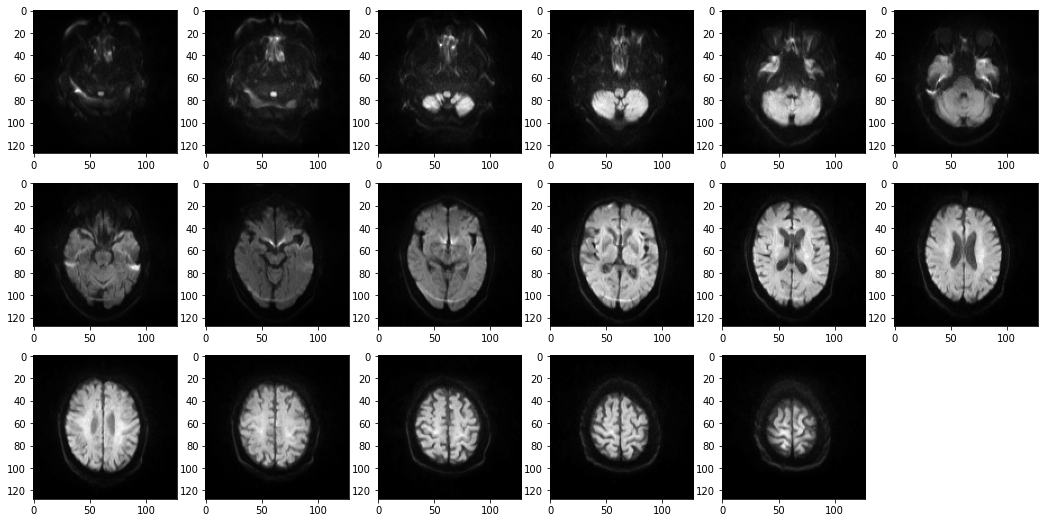

In [7]:
plot_slices(X[30], 0, "axial", "DWI") # patient with cardioembolic cause

# Import clinical and patient data

In [8]:
dat = pd.read_csv(DIR + DATA_DIR + "data_bern_25_11_2020_dwi.csv")
dat.head(3)

,p_id,columns,instance_no,path,rows,sequence,modality,modality_no,folder,image,...,time_to_needle,time_to_groin_puncture,vessel_open_before_therapy,tici,tici_binary,toast,p_id_old,pixel_spacing_x,pixel_spacing_y,pixel_spacing_z
0,442968,192,20,D:\AIM_EXPORT\0000442968\13936379\0000442968_1...,192,ep2d_diff_3scan_trace_p2,DWI,2,13936379,1277138618,...,non,240.0,0,4,1,2,442968,1.197917,1.197917,5.0
1,516341,128,23,D:\AIM_EXPORT\0000516341\13946886\0000516341_1...,128,ep2d_diff_M128_b0_1000_DIN,DWI,1,13946886,1278003845,...,non,211.0,0,4,1,5,516341,1.796875,1.796875,5.0
2,653853,128,26,D:\AIM_EXPORT\0000653853\13960789\0000653853_1...,128,ep2d_diff_M128_b0_1000_DIN,DWI,1,13960789,1279008923,...,non,140.0,0,4,1,4,653853,1.796875,1.796875,5.0


In [9]:
# add image information to define the expert model as in the paper with Janne
dat1 = pd.read_csv(DIR + DATA_DIR + "data_wide_all_nihss.csv", sep = ",")
dat1.head(3)

# check if the patient IDs between datasets match
print(all(dat.p_id.values == dat1.p_id.values))

# attach values 
dat["S_Medm_rbf"] = dat1.S_Medm_rbf.values
dat["volume_adc"] = dat1.volume_adc.values
dat["volume_tar"] = dat1.volume_tar.values
dat["infarct_side"] = dat1.infarct_side

True


In [10]:
# Size of the dataframe: same as the images
dat.shape
dat.head(3)

,p_id,columns,instance_no,path,rows,sequence,modality,modality_no,folder,image,...,tici,tici_binary,toast,p_id_old,pixel_spacing_x,pixel_spacing_y,pixel_spacing_z,S_Medm_rbf,volume_adc,volume_tar
0,442968,192,20,D:\AIM_EXPORT\0000442968\13936379\0000442968_1...,192,ep2d_diff_3scan_trace_p2,DWI,2,13936379,1277138618,...,4,1,2,442968,1.197917,1.197917,5.0,11.351128,0.00,55.73
1,516341,128,23,D:\AIM_EXPORT\0000516341\13946886\0000516341_1...,128,ep2d_diff_M128_b0_1000_DIN,DWI,1,13946886,1278003845,...,4,1,5,516341,1.796875,1.796875,5.0,26.606539,24.05,166.33
2,653853,128,26,D:\AIM_EXPORT\0000653853\13960789\0000653853_1...,128,ep2d_diff_M128_b0_1000_DIN,DWI,1,13960789,1279008923,...,4,1,4,653853,1.796875,1.796875,5.0,36.334002,1.78,40.24


In [11]:
# define binary mRS
dat["mrs_3months_binary"] = 0
dat.loc[dat.mrs_3months <= 2, "mrs_3months_binary"] = 1

In [12]:
# define binary toast score
dat["toast_binary"] = 0
dat.loc[dat.toast == 2, "toast_binary"] = 1

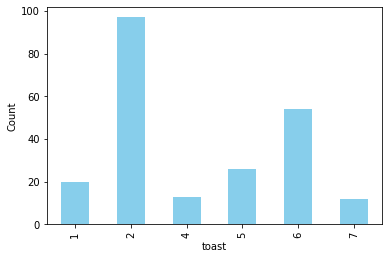

In [13]:
# show distr of toast Score (Stroke Cause)
class_counts = dat['toast'].value_counts().sort_index()
class_counts.plot(kind='bar', color='skyblue')
plt.xlabel('toast')
plt.ylabel('Count')
plt.show()


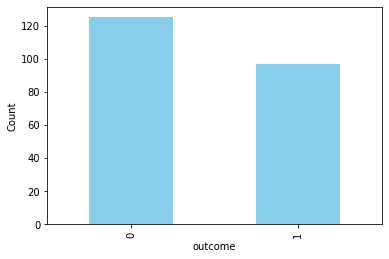

In [14]:
class_counts = dat['toast_binary'].value_counts().sort_index()
class_counts.plot(kind='bar', color='skyblue')
plt.xlabel('outcome')
plt.ylabel('Count')
plt.show()

#### Train, validation and test

In [15]:
# NAs?
[dat.age.isnull().sum(), 
 dat.nihss_bl.isnull().sum(),  
 dat.sys_bloodpressure_bl.isnull().sum(),
 dat.rf_diabetes.isnull().sum(), 
 dat.rf_hypertonia.isnull().sum(), 
 dat.rf_smoker.isnull().sum(),  
 dat.rf_tia_stroke.isnull().sum(), 
 dat.lyse.isnull().sum(),
 dat.time_to_groin_puncture.isnull().sum()]

[0, 0, 8, 0, 0, 20, 0, 0, 7]

In [15]:
# # simple imputation: replace all missing values with the mode of the column
# for column in dat.columns:
#     dat[column].fillna(dat[column].mode()[0], inplace=True)

In [16]:
# use the imputed data from the last project
train0 = pd.read_csv(DIR + DATA_DIR + "train_imputed_all1.csv", sep = ",")
train1 = pd.read_csv(DIR + DATA_DIR + "train_imputed_all2.csv", sep = ",")
train2 = pd.read_csv(DIR + DATA_DIR + "train_imputed_all3.csv", sep = ",")
train3 = pd.read_csv(DIR + DATA_DIR + "train_imputed_all4.csv", sep = ",")
train4 = pd.read_csv(DIR + DATA_DIR + "train_imputed_all5.csv", sep = ",")

test0 = pd.read_csv(DIR + DATA_DIR + "test_imputed_all1.csv", sep = ",")
test1 = pd.read_csv(DIR + DATA_DIR + "test_imputed_all2.csv", sep = ",")
test2 = pd.read_csv(DIR + DATA_DIR + "test_imputed_all3.csv", sep = ",")
test3 = pd.read_csv(DIR + DATA_DIR + "test_imputed_all4.csv", sep = ",")
test4 = pd.read_csv(DIR + DATA_DIR + "test_imputed_all5.csv", sep = ",")

In [17]:
train = [train0, train1, train2, train3, train4]
test = [test0, test1, test2, test3, test4]

In [18]:
# get training and test indices for CV later to impute during CV
train_idxes0 = [train0.index.values, train1.index.values, train2.index.values, train3.index.values, train4.index.values]
test_idxes = [test0.index.values, test1.index.values, test2.index.values, test3.index.values, test4.index.values]

In [19]:
my_seed = 3004

# define validation data
train_idxes = []
valid_idxes = []
for i in range(5):
    np.random.seed(my_seed)
    train_idx, valid_idx = train_test_split(train_idxes0[i], test_size = int(len(train_idxes0[i])*0.15))
    print(valid_idx)
    valid_idxes.append(np.sort(valid_idx))
    train_idxes.append(np.sort(train_idx))
    my_seed += 1
    
# define datasets: train and validation
train_old = train
train = []
valid = []
for f in range(5):
    train.append(train_old[f].loc[train_old[f].index.isin(train_idxes[f]),:])
    valid.append(train_old[f].loc[train_old[f].index.isin(valid_idxes[f]),:])

# get patient IDs
for i in range(5):
    train[i] = train[i].assign(p_id = dat.p_id[train_idxes[i]-1].values)
    valid[i] = valid[i].assign(p_id = dat.p_id[valid_idxes[i]-1].values)
    test[i] = test[i].assign(p_id = dat.p_id[test_idxes[i]-1].values)
    
# get toast score
for i in range(5):
    train[i] = train[i].assign(toast = dat.toast[train_idxes[i]-1].values)
    valid[i] = valid[i].assign(toast = dat.toast[valid_idxes[i]-1].values)
    test[i] = test[i].assign(toast = dat.toast[test_idxes[i]-1].values)

[ 49 110  98  83  18 141 134 218 221  44 139 108  65   4  57 104 151  60
  54 194   3 130 156 128 212 114]
[146  84  56  49 188  95 106 147 139  26  53 133 183 152 155 143 207  88
   5 206 102 179 120 128  65 181]
[ 34  41  96  35 188  53  57 190 120  69  40   3  45 146  59 134 220 127
 130  64  78 108 153   4  21 165]
[214 185  12  55 178  36 166  76 133  82 153  26  73 141 118 107  81 139
 115  70 123  31  83 197  69 184]
[122   4  98 219 107  97 191 156  67  93 113  91 130 169 134 153  63  77
 148  40  35 116 183 171 212  45]


In [22]:
# check if indices overlap
# np.sort(train[0].index.values)
# np.sort(valid[0].index.values)
# np.sort(test[0].index.values)

In [23]:
# save imputed datasets with p_id, toast and image information
#for i in range(5):
#    train[i].to_csv(DIR + DATA_DIR + "train_imputed_all" + str(i) + "_cause.csv", sep = ",")
#for i in range(5):
#    test[i].to_csv(DIR + DATA_DIR + "test_imputed_all" + str(i) + "_cause.csv", sep = ",")

In [24]:
# #  check if image data still corresponds to tables --> works
# for i in range(5):
#     print(all(train[i].age.values.round(2) == dat.age.values[train_idxes[i]-1].round(2)))
#     print(all(valid[i].age.values.round(2) == dat.age.values[valid_idxes[i]-1].round(2)))
#     print(all(test[i].age.values.round(2) == dat.age.values[test_idxes[i]-1].round(2)))

In [20]:
Y = np.array(dat.toast_binary)
print(Y[0:5])
print(Y.shape)
Y_cat = to_categorical(Y)
print(Y_cat[0:5])
print(Y_cat.shape)


[1 0 0 1 0]
(222,)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
(222, 2)


# Define models

In [21]:
# Model for the intercept function: C = number of classes
def mod_baseline(C):
    mod = keras.Sequential(name = "mod_baseline")
    mod.add(keras.Input(shape = (1, )))
    mod.add(keras.layers.Dense(C - 1, activation = "linear", use_bias = False, name="lastlayer_bl"))
    return mod

# Model for linear shift terms
def mod_linear_shift(x):
    mod = keras.Sequential(name = "mod_linear_shift")
    mod.add(keras.Input(shape = (x, )))
    mod.add(keras.layers.Dense(1, activation = "linear", use_bias = False, name="lastlayer_LSx"))
    return mod

# Model for complex shift terms
def mod_complex_shift(x):
    mod = keras.Sequential(name = "mod_complex_shift")
    mod.add(keras.Input(shape = (x, )))
    mod.add(keras.layers.Dense(8, activation = "relu"))
    mod.add(keras.layers.Dense(8, activation = "relu"))
    mod.add(keras.layers.Dense(1, activation = "linear", use_bias = False, name="lastlayer_CSb"))
    return mod  

In [22]:
def img_model_3D(input_shape, output_shape, input_name, activation = "linear"): # Input shape: (128, 128, 20, 3)
    in_ = keras.Input(shape = input_shape, name = input_name)
    x = layers.Convolution3D(32, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(in_)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.Convolution3D(32, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.Convolution3D(64, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.Convolution3D(64, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.Convolution3D(128, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Dropout(0.3)(x)
    out_ = layers.Dense(output_shape, activation = activation, use_bias = False, name="lastlayer_img_mod")(x)
    nn_im = keras.Model(inputs = in_, outputs = out_)
    return nn_im

mod = img_model_3D(X.shape[1:], 1, 'im_in', 'sigmoid')
mod.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
im_in (InputLayer)           [(None, 128, 128, 20, 3)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 128, 128, 20, 32)  2624      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 20, 32)  128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 64, 64, 10, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 64, 10, 32)    27680     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 10, 32)    128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 32, 5, 32)     0     

In [23]:
X.shape[0:]

(222, 128, 128, 20, 3)

# ONTRAMs

## Complex Intercept (CI)

In [25]:
folder_name = "CI/"
batch_size = 8
C = 2 # binary outcome
epochs = 250
# # create folders: run only once
#os.mkdir(OUTPUT_DIR + folder_name)
#for i in range(5):
#    os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i))
#    for j in range(5):
#        os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i) + "/run" + str(j))

In [54]:
# function for plots while training
from functions.keras_training_progress import PlotLearning

In [55]:
# def function for preprocessing
def train_preprocessing(data, label):
    """Process training data."""
    volume = data # shift: image
    volume = zoom(volume)
    volume = rotate(volume)
    volume = shift(volume)
    volume = flip(volume)
    return volume, label

In [ ]:
j = 0
my_seed = 1

nll = np.empty((5, 1))
estimates = np.empty((5, C-1)) # C-1 intercepts, 0 variables

for f in range(len(train_idxes)):
    
    # Load data for fold f
    train_idx = train_idxes[f]
    test_idx = test_idxes[f]
    valid_idx = valid_idxes[f]

    X_train = X[train_idx-1]
    X_valid = X[valid_idx-1]
    X_test = X[test_idx-1]

    Y_train = Y_cat[train_idx-1]
    Y_valid = Y_cat[valid_idx-1]
    Y_test = Y_cat[test_idx-1]

    dat_train = train[f]
    dat_valid = valid[f]
    dat_test = test[f]

    dat_train.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(f) + "/" + "dat_train.csv", index = False)
    dat_valid.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(f) + "/" + "dat_valid.csv", index = False)
    dat_test.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(f) + "/" + "dat_test.csv", index = False)    


    # Define datasets

    train_data = tf.data.Dataset.from_tensor_slices((X_train))
    train_labels = tf.data.Dataset.from_tensor_slices((Y_train))

    valid_data = tf.data.Dataset.from_tensor_slices((X_valid))
    valid_labels = tf.data.Dataset.from_tensor_slices((Y_valid))

    test_data = tf.data.Dataset.from_tensor_slices((X_test))
    test_labels = tf.data.Dataset.from_tensor_slices((Y_test))

    train_loader = tf.data.Dataset.zip((train_data, train_labels))
    validation_loader = tf.data.Dataset.zip((valid_data, valid_labels))
    test_loader = tf.data.Dataset.zip((test_data, test_labels))

    train_dataset = (train_loader.shuffle(len(X_train))
                     .map(train_preprocessing)
                     .batch(batch_size, drop_remainder = True))
    validation_dataset = (validation_loader.batch(batch_size, drop_remainder = True))
    
    test_dataset = (test_loader.batch(len(X_test)))
    
    
    # Training ---------------------------------------------------------------------
    
    for i in range(5):
        
        # define model
        img_model = img_model_3D(X_train.shape[1:], C-1, 'im_in', 'linear')
        model = ontram(img_model)
        
        # save final model
        checkpoint_filepath = OUTPUT_DIR + folder_name + "fold" + str(j) + "/" + "run" + str(i) + "/"
        
        # compile and train
        model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-4),
                      loss = ontram_loss(C, batch_size),
                      metrics = [ontram_acc(C, batch_size)])
        
        checkpoint_cb = keras.callbacks.ModelCheckpoint(
            filepath = checkpoint_filepath + "model_weights.hdf5",
            save_weights_only = True,
            monitor = "val_loss",
            mode = 'min',
            save_best_only = True)
        early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=80, restore_best_weights=True)
    
        callbacks_list = [checkpoint_cb, early_stopping_cb]

        
        history = model.fit(train_dataset,
                            validation_data = validation_dataset,
                            epochs = epochs,
                            shuffle = True,
                            verbose = 2,
                            callbacks = callbacks_list)
        
        pd.DataFrame(history.history).to_csv(checkpoint_filepath + "history.csv", index = False)
        #model.save_weights(checkpoint_filepath + "model_weights.hdf5")
        
        # Do predictions
        test_batch_size = len(X_test)
        model.compile(loss = ontram_loss(C, test_batch_size))
        preds = predict_ontram(model, data = test_dataset)
        params = get_parameters(model)
        
        # save predictions/parameters
        cdf = pd.DataFrame(preds["cdf"])
        cdf.columns = ["y_pred" + str(i) for i in range(C+1)]
        cdf["p_id"] = dat_test.p_id.values
        cdf["y_true"] = np.argmax(Y_test, axis=1)
        cdf.to_csv(checkpoint_filepath + "cdf.csv", index = False)  
        
        pdf = pd.DataFrame(preds["pdf"])
        pdf.columns = ["y_pred" + str(i) for i in range(C)]
        pdf["p_id"] = dat_test.p_id.values
        pdf["y_true"] = np.argmax(Y_test, axis=1)
        pdf.to_csv(checkpoint_filepath + "pdf.csv", index = False)
        
        nll[i] = preds["nll"]
    
    pd.DataFrame(nll).to_csv(OUTPUT_DIR + folder_name + "/fold" + str(j) + "/nll.csv", index = False)
    
    j += 1

Epoch 1/250
19/19 - 39s - loss: 1.1328 - acc: 0.4474 - val_loss: 0.9899 - val_acc: 0.4583
Epoch 2/250
19/19 - 38s - loss: 0.8726 - acc: 0.5197 - val_loss: 1.2013 - val_acc: 0.5000
Epoch 3/250


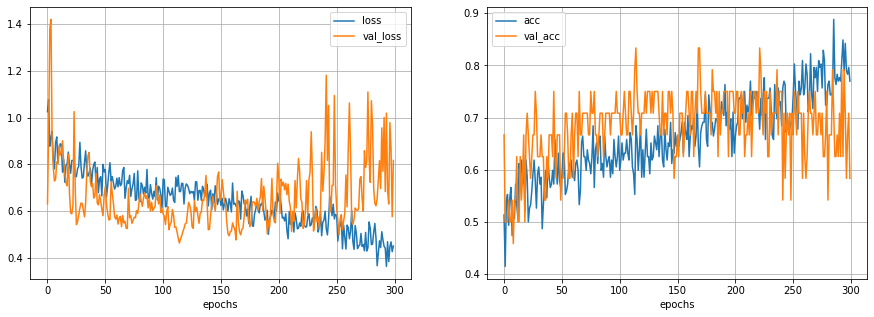

In [45]:
# lr = 1e-4

# plot training history
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'],label = "val_loss")
plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.subplot(1,2,2)
plt.plot(history.history['acc'], label = "acc")
plt.plot(history.history['val_acc'],label = "val_acc")
plt.xlabel('epochs')
plt.legend()
plt.grid()
plt.show()

In [64]:
img_model = img_model_3D(X_train.shape[1:], C-1, 'im_in', 'linear')
model = ontram(img_model)

# compile and train
model.compile(optimizer = keras.optimizers.Adam(),
            loss = ontram_loss(C, batch_size),
            metrics = [ontram_acc(C, batch_size)])

import warnings
warnings.filterwarnings("ignore")


for f in range(0,5):
    cfp = OUTPUT_DIR + folder_name + "/" + "fold" + str(f) + "/" + "run" + str(0) + "/"
    
    train_idx = train_idxes[f]
    test_idx = test_idxes[f]
    valid_idx = valid_idxes[f]

    X_train = X[train_idx-1]
    X_valid = X[valid_idx-1]
    X_test = X[test_idx-1]

    Y_train = Y_cat[train_idx-1]
    Y_valid = Y_cat[valid_idx-1]
    Y_test = Y_cat[test_idx-1]

    dat_train = train[f]
    dat_valid = valid[f]
    dat_test = test[f]    

    # Define datasets

    train_data = tf.data.Dataset.from_tensor_slices((X_train))
    train_labels = tf.data.Dataset.from_tensor_slices((Y_train))

    valid_data = tf.data.Dataset.from_tensor_slices((X_valid))
    valid_labels = tf.data.Dataset.from_tensor_slices((Y_valid))

    test_data = tf.data.Dataset.from_tensor_slices((X_test))
    test_labels = tf.data.Dataset.from_tensor_slices((Y_test))

    train_loader = tf.data.Dataset.zip((train_data, train_labels))
    validation_loader = tf.data.Dataset.zip((valid_data, valid_labels))
    test_loader = tf.data.Dataset.zip((test_data, test_labels))

    train_dataset = (train_loader.shuffle(len(X_train))
                     .map(train_preprocessing)
                     .batch(batch_size, drop_remainder = True))
    validation_dataset = (validation_loader.batch(batch_size, drop_remainder = True))
    
    test_dataset = (test_loader.batch(len(X_test)))
    
    
    # Do predictions for each fold
    
    hist = pd.read_csv(cfp + "history.csv")
    model.load_weights(cfp + "model_weights.hdf5")
    
    test_batch_size = len(X_test)
    model.compile(loss = ontram_loss(C, test_batch_size))
    preds = predict_ontram(model, data = test_dataset)


    # save predictions/parameters for each fold
    
    cdf = pd.DataFrame(preds["cdf"])
    cdf.columns = ["y_pred" + str(i) for i in range(C+1)]
    cdf["p_id"] = dat_test.p_id.values
    cdf["y_true"] = np.argmax(Y_test, axis=1)
    cdf.to_csv(cfp + "cdf.csv", index = False) 

    pdf = pd.DataFrame(preds["pdf"])
    pdf.columns = ["y_pred" + str(i) for i in range(C)]
    pdf["p_id"] = dat_test.p_id.values
    pdf["y_true"] = np.argmax(Y_test, axis=1)
    pdf["y_pred"] = tf.argmax(preds["pdf"], axis = 1)
    pdf.to_csv(cfp + "pdf.csv", index = False)

    nll = preds["nll"]
    acc = skm.accuracy_score(pdf.y_true, pdf.y_pred)
    auc = skm.roc_auc_score(y_true = pdf.y_true, y_score = pdf.y_pred)

    score_matrix = [
        ["Accuracy", round(acc, 2)],
        ["AUC", round(auc,2)],
        ["NLL", round(nll,2)]
    ]

    for row in score_matrix:
        print("{:<10} {:<10}".format(row[0], row[1]))

Accuracy   0.61      
AUC        0.61      
NLL        0.6899999976158142
Accuracy   0.55      
AUC        0.52      
NLL        0.7200000286102295
Accuracy   0.41      
AUC        0.34      
NLL        0.7599999904632568
Accuracy   0.49      
AUC        0.51      
NLL        0.7400000095367432
Accuracy   0.47      
AUC        0.47      
NLL        0.8899999856948853


## SI_LSx

In [32]:
folder_name = "SI_LSx/"
batch_size = 8
C = 2 # binary outcome
epochs = 300
## create folders: run only once
#os.mkdir(OUTPUT_DIR + folder_name)
#for i in range(5):
#    os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i))
#    for j in range(5):
#        os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i) + "/run" + str(j))

In [33]:
j = 0
my_seed = 1

nll = np.empty((5, 1))
estimates = np.empty((5, C-1+12)) # 1 intercept, 12 variables
estimates_sd = np.empty((5, C-1+12)) # 1 intercept, 12 variables

for f in range(len(train_idxes)):
    
    train_idx = train_idxes[f]
    test_idx = test_idxes[f]
    valid_idx = valid_idxes[f]
    
    # Load data for fold j ------------------------------------------------------
    
    # define datasets
    X_tab_train = np.array([train[f].age, train[f].sex, train[f].antikoagulation_pre_stroke,
                            train[f].atrial_fibrillation, train[f].nihss_bl, train[f].sys_bloodpressure_bl, 
                            train[f].rf_diabetes, train[f].rf_hypertonia, train[f].rf_smoker, 
                            train[f].rf_tia_stroke, train[f].lyse, train[f].time_to_groin_puncture]).T
    X_tab_valid = np.array([valid[f].age, valid[f].sex, valid[f].antikoagulation_pre_stroke,
                            valid[f].atrial_fibrillation, valid[f].nihss_bl, valid[f].sys_bloodpressure_bl, 
                            valid[f].rf_diabetes, valid[f].rf_hypertonia, valid[f].rf_smoker, 
                            valid[f].rf_tia_stroke, valid[f].lyse, valid[f].time_to_groin_puncture]).T
    X_tab_test = np.array([test[f].age, test[f].sex, test[f].antikoagulation_pre_stroke,
                            test[f].atrial_fibrillation, test[f].nihss_bl, test[f].sys_bloodpressure_bl, 
                            test[f].rf_diabetes, test[f].rf_hypertonia, test[f].rf_smoker, 
                            test[f].rf_tia_stroke, test[f].lyse, test[f].time_to_groin_puncture]).T
    
    # normalize
    sd = np.empty((12,))
    for i in range(X_tab_train.shape[1]):
        train_mean = np.mean(X_tab_train[:,i])
        train_std = np.std(X_tab_train[:,i])
        X_tab_train[:,i] = (X_tab_train[:,i] - train_mean) / train_std
        X_tab_valid[:,i] = (X_tab_valid[:,i] - train_mean) / train_std
        X_tab_test[:,i] = (X_tab_test[:,i] - train_mean) / train_std
        sd[i] = train_std
    
    Y_train = Y_cat[train_idx-1]
    Y_valid = Y_cat[valid_idx-1]
    Y_test = Y_cat[test_idx-1]
    
    dat_train = train[f]
    dat_valid = valid[f]
    dat_test = test[f]
    
    dat_train.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(j) + "/" + "dat_train.csv", index = False)
    dat_valid.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(j) + "/" + "dat_valid.csv", index = False)
    dat_test.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(j) + "/" + "dat_test.csv", index = False)
    
    
    # Define datasets for ONTRAM ------------------------------------------------------
    
    train_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_tab_train),1]), X_tab_train))
    train_labels = tf.data.Dataset.from_tensor_slices((Y_train))
    
    valid_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_tab_valid),1]), X_tab_valid))
    valid_labels = tf.data.Dataset.from_tensor_slices((Y_valid))

    test_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_tab_test),1]), X_tab_test))
    test_labels = tf.data.Dataset.from_tensor_slices((Y_test))
    
    train_loader = tf.data.Dataset.zip((train_data, train_labels))
    validation_loader = tf.data.Dataset.zip((valid_data, valid_labels))
    test_loader = tf.data.Dataset.zip((test_data, test_labels))
    
    train_dataset = (train_loader.shuffle(len(X_tab_train)).batch(batch_size, drop_remainder=True))
    validation_dataset = (validation_loader.batch(batch_size, drop_remainder=True))
    test_dataset = (test_loader.batch(len(X_tab_test)))
    
    
    # Training ---------------------------------------------------------------------
    
    for i in range(5):
        
        # define model
        mbl = mod_baseline(C)
        mls = mod_linear_shift(X_tab_train.shape[1])
        model = ontram(mbl, mls)
        
        # save final model
        checkpoint_filepath = OUTPUT_DIR + folder_name + "fold" + str(j) + "/" + "run" + str(i) + "/"
        
        # compile and train
        model.compile(optimizer = keras.optimizers.Adam(),
                      loss = ontram_loss(C, batch_size),
                      metrics = [ontram_acc(C, batch_size)])
        
        checkpoint_cb = keras.callbacks.ModelCheckpoint(
            filepath = checkpoint_filepath + "model_weights.hdf5",
            save_weights_only = True,
            monitor = "val_loss",
            mode = 'min',
            save_best_only = True)
        early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
    
        callbacks_list = [checkpoint_cb, early_stopping_cb]
        
        history = model.fit(train_dataset,
                            validation_data = validation_dataset,
                            epochs = epochs,
                            shuffle = True,
                            verbose = 2,
                            callbacks = callbacks_list)
        
        pd.DataFrame(history.history).to_csv(checkpoint_filepath + "history.csv", index = False)
        #model.save_weights(checkpoint_filepath + "model_weights.hdf5")
        
        # Do predictions
        test_batch_size = len(X_tab_test)
        model.compile(loss = ontram_loss(C, test_batch_size))
        preds = predict_ontram(model, data = test_dataset)
        params = get_parameters(model)
        
        # save predictions/parameters
        cdf = pd.DataFrame(preds["cdf"])
        cdf.columns = ["y_pred" + str(i) for i in range(C+1)]
        cdf["p_id"] = dat_test.p_id.values
        cdf["y_true"] = np.argmax(Y_test, axis=1)
        cdf.to_csv(checkpoint_filepath + "cdf.csv", index = False)  
        
        pdf = pd.DataFrame(preds["pdf"])
        pdf.columns = ["y_pred" + str(i) for i in range(C)]
        pdf["p_id"] = dat_test.p_id.values
        pdf["y_true"] = np.argmax(Y_test, axis=1)
        pdf.to_csv(checkpoint_filepath + "pdf.csv", index = False)
        
        nll[i] = preds["nll"]
        estimates[i] = np.concatenate((params["intercept"][0][0][0], np.concatenate(params["shift"][0][0][0]))) 
        estimates_sd[i] = np.concatenate((params["intercept"][0][0][0], np.concatenate(params["shift"][0][0][0])/sd)) 
    
    pd.DataFrame(nll).to_csv(OUTPUT_DIR + folder_name + "fold" + str(j) + "/nll.csv", index = False)
    
    pd_estimates = pd.DataFrame(estimates)
    pd_estimates.columns = ["intercept0", "age", "sex", "antikoagulation_pre_stroke",
                            "atrial_fibrillation", "nihss_bl", "sys_bloodpressure_bl", "rf_diabetes", 
                            "rf_hypertonia", "rf_smoker", "rf_tia_stroke", "lyse", "time_to_groin_puncture"]
    pd_estimates.to_csv(OUTPUT_DIR + folder_name + "/fold" + str(j) + "/estimates.csv", index = False)
    pd_estimates_sd = pd.DataFrame(estimates_sd)
    pd_estimates_sd.columns = ["intercept0", "age", "sex", "antikoagulation_pre_stroke",
                               "atrial_fibrillation", "nihss_bl", "sys_bloodpressure_bl", "rf_diabetes", 
                               "rf_hypertonia", "rf_smoker", "rf_tia_stroke", "lyse", "time_to_groin_puncture"]
    pd_estimates_sd.to_csv(OUTPUT_DIR + folder_name + "fold" + str(j) + "/estimates_sd.csv", index = False)
    
    j += 1

Epoch 1/300
19/19 - 0s - loss: 0.7084 - acc: 0.6645 - val_loss: 0.7255 - val_acc: 0.6667
Epoch 2/300
19/19 - 0s - loss: 0.6933 - acc: 0.6645 - val_loss: 0.7192 - val_acc: 0.6667
Epoch 3/300
19/19 - 0s - loss: 0.6782 - acc: 0.6842 - val_loss: 0.7127 - val_acc: 0.6667
Epoch 4/300
19/19 - 0s - loss: 0.6636 - acc: 0.6842 - val_loss: 0.7072 - val_acc: 0.6667
Epoch 5/300
19/19 - 0s - loss: 0.6508 - acc: 0.6908 - val_loss: 0.7012 - val_acc: 0.7083
Epoch 6/300
19/19 - 0s - loss: 0.6363 - acc: 0.6974 - val_loss: 0.6956 - val_acc: 0.7083
Epoch 7/300
19/19 - 0s - loss: 0.6228 - acc: 0.7039 - val_loss: 0.6914 - val_acc: 0.7500
Epoch 8/300
19/19 - 0s - loss: 0.6103 - acc: 0.7039 - val_loss: 0.6857 - val_acc: 0.7917
Epoch 9/300
19/19 - 0s - loss: 0.5977 - acc: 0.7171 - val_loss: 0.6804 - val_acc: 0.7917
Epoch 10/300
19/19 - 0s - loss: 0.5850 - acc: 0.7303 - val_loss: 0.6757 - val_acc: 0.7917
Epoch 11/300
19/19 - 0s - loss: 0.5737 - acc: 0.7303 - val_loss: 0.6711 - val_acc: 0.7917
Epoch 12/300
19/19 

19/19 - 0s - loss: 0.2277 - acc: 0.9211 - val_loss: 0.4923 - val_acc: 0.9167
Epoch 93/300
19/19 - 0s - loss: 0.2269 - acc: 0.9211 - val_loss: 0.4909 - val_acc: 0.9167
Epoch 94/300
19/19 - 0s - loss: 0.2257 - acc: 0.9211 - val_loss: 0.4898 - val_acc: 0.9167
Epoch 95/300
19/19 - 0s - loss: 0.2247 - acc: 0.9276 - val_loss: 0.4885 - val_acc: 0.9167
Epoch 96/300
19/19 - 0s - loss: 0.2237 - acc: 0.9276 - val_loss: 0.4878 - val_acc: 0.9167
Epoch 97/300
19/19 - 0s - loss: 0.2228 - acc: 0.9276 - val_loss: 0.4864 - val_acc: 0.9167
Epoch 98/300
19/19 - 0s - loss: 0.2218 - acc: 0.9276 - val_loss: 0.4856 - val_acc: 0.9167
Epoch 99/300
19/19 - 0s - loss: 0.2210 - acc: 0.9276 - val_loss: 0.4841 - val_acc: 0.9167
Epoch 100/300
19/19 - 0s - loss: 0.2201 - acc: 0.9276 - val_loss: 0.4831 - val_acc: 0.9167
Epoch 101/300
19/19 - 0s - loss: 0.2193 - acc: 0.9276 - val_loss: 0.4818 - val_acc: 0.9167
Epoch 102/300
19/19 - 0s - loss: 0.2183 - acc: 0.9276 - val_loss: 0.4803 - val_acc: 0.9167
Epoch 103/300
19/19 

Epoch 183/300
19/19 - 0s - loss: 0.1842 - acc: 0.9276 - val_loss: 0.4245 - val_acc: 0.9583
Epoch 184/300
19/19 - 0s - loss: 0.1840 - acc: 0.9342 - val_loss: 0.4239 - val_acc: 0.9583
Epoch 185/300
19/19 - 0s - loss: 0.1839 - acc: 0.9342 - val_loss: 0.4230 - val_acc: 0.9583
Epoch 186/300
19/19 - 0s - loss: 0.1836 - acc: 0.9342 - val_loss: 0.4232 - val_acc: 0.9583
Epoch 187/300
19/19 - 0s - loss: 0.1834 - acc: 0.9342 - val_loss: 0.4228 - val_acc: 0.9583
Epoch 188/300
19/19 - 0s - loss: 0.1832 - acc: 0.9342 - val_loss: 0.4227 - val_acc: 0.9583
Epoch 189/300
19/19 - 0s - loss: 0.1831 - acc: 0.9342 - val_loss: 0.4222 - val_acc: 0.9583
Epoch 190/300
19/19 - 0s - loss: 0.1828 - acc: 0.9342 - val_loss: 0.4213 - val_acc: 0.9583
Epoch 191/300
19/19 - 0s - loss: 0.1827 - acc: 0.9342 - val_loss: 0.4216 - val_acc: 0.9583
Epoch 192/300
19/19 - 0s - loss: 0.1825 - acc: 0.9342 - val_loss: 0.4203 - val_acc: 0.9583
Epoch 193/300
19/19 - 0s - loss: 0.1823 - acc: 0.9342 - val_loss: 0.4203 - val_acc: 0.9583

Epoch 274/300
19/19 - 0s - loss: 0.1734 - acc: 0.9408 - val_loss: 0.4072 - val_acc: 0.9583
Epoch 275/300
19/19 - 0s - loss: 0.1733 - acc: 0.9408 - val_loss: 0.4068 - val_acc: 0.9583
Epoch 276/300
19/19 - 0s - loss: 0.1733 - acc: 0.9408 - val_loss: 0.4071 - val_acc: 0.9583
Epoch 277/300
19/19 - 0s - loss: 0.1732 - acc: 0.9408 - val_loss: 0.4069 - val_acc: 0.9583
Epoch 278/300
19/19 - 0s - loss: 0.1733 - acc: 0.9408 - val_loss: 0.4076 - val_acc: 0.9583
Epoch 279/300
19/19 - 0s - loss: 0.1731 - acc: 0.9408 - val_loss: 0.4069 - val_acc: 0.9583
Epoch 280/300
19/19 - 0s - loss: 0.1731 - acc: 0.9408 - val_loss: 0.4065 - val_acc: 0.9583
Epoch 281/300
19/19 - 0s - loss: 0.1729 - acc: 0.9408 - val_loss: 0.4071 - val_acc: 0.9583
Epoch 282/300
19/19 - 0s - loss: 0.1730 - acc: 0.9408 - val_loss: 0.4069 - val_acc: 0.9583
Epoch 283/300
19/19 - 0s - loss: 0.1728 - acc: 0.9408 - val_loss: 0.4070 - val_acc: 0.9583
Epoch 284/300
19/19 - 0s - loss: 0.1729 - acc: 0.9408 - val_loss: 0.4065 - val_acc: 0.9583

Epoch 65/300
19/19 - 0s - loss: 0.5206 - acc: 0.6974 - val_loss: 0.6311 - val_acc: 0.6667
Epoch 66/300
19/19 - 0s - loss: 0.5137 - acc: 0.7105 - val_loss: 0.6281 - val_acc: 0.6667
Epoch 67/300
19/19 - 0s - loss: 0.5067 - acc: 0.7171 - val_loss: 0.6250 - val_acc: 0.6667
Epoch 68/300
19/19 - 0s - loss: 0.4999 - acc: 0.7303 - val_loss: 0.6221 - val_acc: 0.6667
Epoch 69/300
19/19 - 0s - loss: 0.4934 - acc: 0.7434 - val_loss: 0.6192 - val_acc: 0.6667
Epoch 70/300
19/19 - 0s - loss: 0.4868 - acc: 0.7566 - val_loss: 0.6165 - val_acc: 0.6667
Epoch 71/300
19/19 - 0s - loss: 0.4806 - acc: 0.7566 - val_loss: 0.6136 - val_acc: 0.6667
Epoch 72/300
19/19 - 0s - loss: 0.4745 - acc: 0.7632 - val_loss: 0.6106 - val_acc: 0.6667
Epoch 73/300
19/19 - 0s - loss: 0.4685 - acc: 0.7697 - val_loss: 0.6087 - val_acc: 0.6667
Epoch 74/300
19/19 - 0s - loss: 0.4627 - acc: 0.7697 - val_loss: 0.6060 - val_acc: 0.6667
Epoch 75/300
19/19 - 0s - loss: 0.4571 - acc: 0.7763 - val_loss: 0.6029 - val_acc: 0.6667
Epoch 76/3

Epoch 156/300
19/19 - 0s - loss: 0.2421 - acc: 0.9276 - val_loss: 0.4594 - val_acc: 0.8750
Epoch 157/300
19/19 - 0s - loss: 0.2410 - acc: 0.9276 - val_loss: 0.4584 - val_acc: 0.8750
Epoch 158/300
19/19 - 0s - loss: 0.2399 - acc: 0.9276 - val_loss: 0.4576 - val_acc: 0.8750
Epoch 159/300
19/19 - 0s - loss: 0.2390 - acc: 0.9276 - val_loss: 0.4560 - val_acc: 0.8750
Epoch 160/300
19/19 - 0s - loss: 0.2379 - acc: 0.9276 - val_loss: 0.4557 - val_acc: 0.8750
Epoch 161/300
19/19 - 0s - loss: 0.2370 - acc: 0.9276 - val_loss: 0.4546 - val_acc: 0.8750
Epoch 162/300
19/19 - 0s - loss: 0.2359 - acc: 0.9276 - val_loss: 0.4532 - val_acc: 0.8750
Epoch 163/300
19/19 - 0s - loss: 0.2351 - acc: 0.9276 - val_loss: 0.4520 - val_acc: 0.8750
Epoch 164/300
19/19 - 0s - loss: 0.2340 - acc: 0.9211 - val_loss: 0.4512 - val_acc: 0.8750
Epoch 165/300
19/19 - 0s - loss: 0.2332 - acc: 0.9211 - val_loss: 0.4502 - val_acc: 0.8750
Epoch 166/300
19/19 - 0s - loss: 0.2323 - acc: 0.9211 - val_loss: 0.4489 - val_acc: 0.8750

19/19 - 0s - loss: 0.1912 - acc: 0.9408 - val_loss: 0.3949 - val_acc: 0.9167
Epoch 247/300
19/19 - 0s - loss: 0.1909 - acc: 0.9408 - val_loss: 0.3946 - val_acc: 0.9167
Epoch 248/300
19/19 - 0s - loss: 0.1907 - acc: 0.9408 - val_loss: 0.3943 - val_acc: 0.9167
Epoch 249/300
19/19 - 0s - loss: 0.1903 - acc: 0.9408 - val_loss: 0.3938 - val_acc: 0.9167
Epoch 250/300
19/19 - 0s - loss: 0.1901 - acc: 0.9408 - val_loss: 0.3932 - val_acc: 0.9167
Epoch 251/300
19/19 - 0s - loss: 0.1899 - acc: 0.9408 - val_loss: 0.3935 - val_acc: 0.9167
Epoch 252/300
19/19 - 0s - loss: 0.1896 - acc: 0.9408 - val_loss: 0.3928 - val_acc: 0.9167
Epoch 253/300
19/19 - 0s - loss: 0.1893 - acc: 0.9408 - val_loss: 0.3923 - val_acc: 0.9583
Epoch 254/300
19/19 - 0s - loss: 0.1892 - acc: 0.9408 - val_loss: 0.3917 - val_acc: 0.9583
Epoch 255/300
19/19 - 0s - loss: 0.1889 - acc: 0.9408 - val_loss: 0.3915 - val_acc: 0.9583
Epoch 256/300
19/19 - 0s - loss: 0.1886 - acc: 0.9408 - val_loss: 0.3916 - val_acc: 0.9583
Epoch 257/300

Epoch 29/300
19/19 - 0s - loss: 0.5047 - acc: 0.7434 - val_loss: 0.8256 - val_acc: 0.6250
Epoch 30/300
19/19 - 0s - loss: 0.4968 - acc: 0.7434 - val_loss: 0.8178 - val_acc: 0.6250
Epoch 31/300
19/19 - 0s - loss: 0.4887 - acc: 0.7566 - val_loss: 0.8113 - val_acc: 0.6250
Epoch 32/300
19/19 - 0s - loss: 0.4814 - acc: 0.7566 - val_loss: 0.8038 - val_acc: 0.6250
Epoch 33/300
19/19 - 0s - loss: 0.4745 - acc: 0.7566 - val_loss: 0.7960 - val_acc: 0.6250
Epoch 34/300
19/19 - 0s - loss: 0.4671 - acc: 0.7697 - val_loss: 0.7889 - val_acc: 0.6250
Epoch 35/300
19/19 - 0s - loss: 0.4603 - acc: 0.7763 - val_loss: 0.7824 - val_acc: 0.6250
Epoch 36/300
19/19 - 0s - loss: 0.4536 - acc: 0.7763 - val_loss: 0.7752 - val_acc: 0.6250
Epoch 37/300
19/19 - 0s - loss: 0.4469 - acc: 0.7961 - val_loss: 0.7686 - val_acc: 0.6250
Epoch 38/300
19/19 - 0s - loss: 0.4406 - acc: 0.7961 - val_loss: 0.7614 - val_acc: 0.6250
Epoch 39/300
19/19 - 0s - loss: 0.4345 - acc: 0.8026 - val_loss: 0.7549 - val_acc: 0.6250
Epoch 40/3

Epoch 120/300
19/19 - 0s - loss: 0.2252 - acc: 0.9276 - val_loss: 0.4768 - val_acc: 0.8750
Epoch 121/300
19/19 - 0s - loss: 0.2243 - acc: 0.9276 - val_loss: 0.4752 - val_acc: 0.8750
Epoch 122/300
19/19 - 0s - loss: 0.2235 - acc: 0.9276 - val_loss: 0.4734 - val_acc: 0.8750
Epoch 123/300
19/19 - 0s - loss: 0.2226 - acc: 0.9276 - val_loss: 0.4725 - val_acc: 0.8750
Epoch 124/300
19/19 - 0s - loss: 0.2219 - acc: 0.9276 - val_loss: 0.4709 - val_acc: 0.8750
Epoch 125/300
19/19 - 0s - loss: 0.2211 - acc: 0.9276 - val_loss: 0.4688 - val_acc: 0.8750
Epoch 126/300
19/19 - 0s - loss: 0.2203 - acc: 0.9276 - val_loss: 0.4673 - val_acc: 0.8750
Epoch 127/300
19/19 - 0s - loss: 0.2196 - acc: 0.9276 - val_loss: 0.4662 - val_acc: 0.8750
Epoch 128/300
19/19 - 0s - loss: 0.2188 - acc: 0.9276 - val_loss: 0.4648 - val_acc: 0.8750
Epoch 129/300
19/19 - 0s - loss: 0.2181 - acc: 0.9276 - val_loss: 0.4634 - val_acc: 0.8750
Epoch 130/300
19/19 - 0s - loss: 0.2174 - acc: 0.9276 - val_loss: 0.4622 - val_acc: 0.8750

19/19 - 0s - loss: 0.1860 - acc: 0.9342 - val_loss: 0.3960 - val_acc: 0.9167
Epoch 211/300
19/19 - 0s - loss: 0.1859 - acc: 0.9342 - val_loss: 0.3962 - val_acc: 0.9167
Epoch 212/300
19/19 - 0s - loss: 0.1856 - acc: 0.9342 - val_loss: 0.3953 - val_acc: 0.9167
Epoch 213/300
19/19 - 0s - loss: 0.1855 - acc: 0.9342 - val_loss: 0.3948 - val_acc: 0.9167
Epoch 214/300
19/19 - 0s - loss: 0.1852 - acc: 0.9342 - val_loss: 0.3943 - val_acc: 0.9167
Epoch 215/300
19/19 - 0s - loss: 0.1851 - acc: 0.9342 - val_loss: 0.3936 - val_acc: 0.9167
Epoch 216/300
19/19 - 0s - loss: 0.1849 - acc: 0.9342 - val_loss: 0.3934 - val_acc: 0.9167
Epoch 217/300
19/19 - 0s - loss: 0.1847 - acc: 0.9342 - val_loss: 0.3932 - val_acc: 0.9167
Epoch 218/300
19/19 - 0s - loss: 0.1845 - acc: 0.9342 - val_loss: 0.3928 - val_acc: 0.9167
Epoch 219/300
19/19 - 0s - loss: 0.1843 - acc: 0.9342 - val_loss: 0.3925 - val_acc: 0.9167
Epoch 220/300
19/19 - 0s - loss: 0.1842 - acc: 0.9342 - val_loss: 0.3917 - val_acc: 0.9167
Epoch 221/300

Epoch 1/300
19/19 - 0s - loss: 0.6001 - acc: 0.7105 - val_loss: 0.7330 - val_acc: 0.6667
Epoch 2/300
19/19 - 0s - loss: 0.5833 - acc: 0.7171 - val_loss: 0.7181 - val_acc: 0.6667
Epoch 3/300
19/19 - 0s - loss: 0.5664 - acc: 0.7237 - val_loss: 0.7051 - val_acc: 0.6667
Epoch 4/300
19/19 - 0s - loss: 0.5504 - acc: 0.7237 - val_loss: 0.6926 - val_acc: 0.6667
Epoch 5/300
19/19 - 0s - loss: 0.5352 - acc: 0.7237 - val_loss: 0.6796 - val_acc: 0.6667
Epoch 6/300
19/19 - 0s - loss: 0.5211 - acc: 0.7500 - val_loss: 0.6685 - val_acc: 0.6667
Epoch 7/300
19/19 - 0s - loss: 0.5076 - acc: 0.7632 - val_loss: 0.6572 - val_acc: 0.7083
Epoch 8/300
19/19 - 0s - loss: 0.4948 - acc: 0.7697 - val_loss: 0.6457 - val_acc: 0.7083
Epoch 9/300
19/19 - 0s - loss: 0.4811 - acc: 0.7763 - val_loss: 0.6372 - val_acc: 0.7083
Epoch 10/300
19/19 - 0s - loss: 0.4698 - acc: 0.7829 - val_loss: 0.6287 - val_acc: 0.7083
Epoch 11/300
19/19 - 0s - loss: 0.4593 - acc: 0.7895 - val_loss: 0.6190 - val_acc: 0.7500
Epoch 12/300
19/19 

Epoch 84/300
19/19 - 0s - loss: 0.2182 - acc: 0.9276 - val_loss: 0.4324 - val_acc: 0.9583
Epoch 85/300
19/19 - 0s - loss: 0.2175 - acc: 0.9276 - val_loss: 0.4319 - val_acc: 0.9583
Epoch 86/300
19/19 - 0s - loss: 0.2167 - acc: 0.9276 - val_loss: 0.4310 - val_acc: 0.9583
Epoch 87/300
19/19 - 0s - loss: 0.2159 - acc: 0.9276 - val_loss: 0.4298 - val_acc: 0.9583
Epoch 88/300
19/19 - 0s - loss: 0.2152 - acc: 0.9276 - val_loss: 0.4290 - val_acc: 0.9583
Epoch 89/300
19/19 - 0s - loss: 0.2144 - acc: 0.9276 - val_loss: 0.4288 - val_acc: 0.9583
Epoch 90/300
19/19 - 0s - loss: 0.2137 - acc: 0.9276 - val_loss: 0.4285 - val_acc: 0.9583
Epoch 91/300
19/19 - 0s - loss: 0.2130 - acc: 0.9276 - val_loss: 0.4276 - val_acc: 0.9583
Epoch 92/300
19/19 - 0s - loss: 0.2124 - acc: 0.9276 - val_loss: 0.4270 - val_acc: 0.9583
Epoch 93/300
19/19 - 0s - loss: 0.2117 - acc: 0.9276 - val_loss: 0.4271 - val_acc: 0.9583
Epoch 94/300
19/19 - 0s - loss: 0.2110 - acc: 0.9276 - val_loss: 0.4260 - val_acc: 0.9583
Epoch 95/3

Epoch 175/300
19/19 - 0s - loss: 0.1825 - acc: 0.9408 - val_loss: 0.4006 - val_acc: 0.9583
Epoch 176/300
19/19 - 0s - loss: 0.1824 - acc: 0.9408 - val_loss: 0.4003 - val_acc: 0.9583
Epoch 177/300
19/19 - 0s - loss: 0.1821 - acc: 0.9408 - val_loss: 0.4004 - val_acc: 0.9583
Epoch 178/300
19/19 - 0s - loss: 0.1820 - acc: 0.9408 - val_loss: 0.4004 - val_acc: 0.9583
Epoch 179/300
19/19 - 0s - loss: 0.1818 - acc: 0.9408 - val_loss: 0.4003 - val_acc: 0.9583
Epoch 180/300
19/19 - 0s - loss: 0.1817 - acc: 0.9408 - val_loss: 0.4003 - val_acc: 0.9583
Epoch 181/300
19/19 - 0s - loss: 0.1815 - acc: 0.9408 - val_loss: 0.3999 - val_acc: 0.9583
Epoch 182/300
19/19 - 0s - loss: 0.1813 - acc: 0.9408 - val_loss: 0.3996 - val_acc: 0.9583
Epoch 183/300
19/19 - 0s - loss: 0.1812 - acc: 0.9408 - val_loss: 0.4000 - val_acc: 0.9583
Epoch 184/300
19/19 - 0s - loss: 0.1811 - acc: 0.9408 - val_loss: 0.3993 - val_acc: 0.9583
Epoch 185/300
19/19 - 0s - loss: 0.1809 - acc: 0.9408 - val_loss: 0.3993 - val_acc: 0.9583

Epoch 2/300
19/19 - 0s - loss: 0.7207 - acc: 0.5461 - val_loss: 0.5961 - val_acc: 0.6667
Epoch 3/300
19/19 - 0s - loss: 0.7012 - acc: 0.5724 - val_loss: 0.5858 - val_acc: 0.6667
Epoch 4/300
19/19 - 0s - loss: 0.6824 - acc: 0.5987 - val_loss: 0.5766 - val_acc: 0.6667
Epoch 5/300
19/19 - 0s - loss: 0.6651 - acc: 0.6118 - val_loss: 0.5678 - val_acc: 0.6667
Epoch 6/300
19/19 - 0s - loss: 0.6482 - acc: 0.6118 - val_loss: 0.5582 - val_acc: 0.6667
Epoch 7/300
19/19 - 0s - loss: 0.6321 - acc: 0.6316 - val_loss: 0.5506 - val_acc: 0.6667
Epoch 8/300
19/19 - 0s - loss: 0.6167 - acc: 0.6513 - val_loss: 0.5427 - val_acc: 0.7500
Epoch 9/300
19/19 - 0s - loss: 0.6018 - acc: 0.6579 - val_loss: 0.5363 - val_acc: 0.7500
Epoch 10/300
19/19 - 0s - loss: 0.5876 - acc: 0.6776 - val_loss: 0.5299 - val_acc: 0.7500
Epoch 11/300
19/19 - 0s - loss: 0.5741 - acc: 0.6776 - val_loss: 0.5235 - val_acc: 0.7500
Epoch 12/300
19/19 - 0s - loss: 0.5617 - acc: 0.6908 - val_loss: 0.5175 - val_acc: 0.7500
Epoch 13/300
19/19

19/19 - 0s - loss: 0.2335 - acc: 0.9342 - val_loss: 0.3993 - val_acc: 0.9583
Epoch 94/300
19/19 - 0s - loss: 0.2325 - acc: 0.9342 - val_loss: 0.3986 - val_acc: 0.9583
Epoch 95/300
19/19 - 0s - loss: 0.2315 - acc: 0.9342 - val_loss: 0.3980 - val_acc: 0.9583
Epoch 96/300
19/19 - 0s - loss: 0.2304 - acc: 0.9342 - val_loss: 0.3976 - val_acc: 0.9583
Epoch 97/300
19/19 - 0s - loss: 0.2295 - acc: 0.9342 - val_loss: 0.3979 - val_acc: 0.9583
Epoch 98/300
19/19 - 0s - loss: 0.2284 - acc: 0.9342 - val_loss: 0.3971 - val_acc: 0.9583
Epoch 99/300
19/19 - 0s - loss: 0.2276 - acc: 0.9342 - val_loss: 0.3963 - val_acc: 0.9583
Epoch 100/300
19/19 - 0s - loss: 0.2265 - acc: 0.9342 - val_loss: 0.3961 - val_acc: 0.9583
Epoch 101/300
19/19 - 0s - loss: 0.2258 - acc: 0.9342 - val_loss: 0.3959 - val_acc: 0.9583
Epoch 102/300
19/19 - 0s - loss: 0.2248 - acc: 0.9342 - val_loss: 0.3957 - val_acc: 0.9583
Epoch 103/300
19/19 - 0s - loss: 0.2240 - acc: 0.9342 - val_loss: 0.3949 - val_acc: 0.9583
Epoch 104/300
19/19

Epoch 184/300
19/19 - 0s - loss: 0.1867 - acc: 0.9342 - val_loss: 0.3779 - val_acc: 0.9583
Epoch 185/300
19/19 - 0s - loss: 0.1865 - acc: 0.9342 - val_loss: 0.3776 - val_acc: 0.9583
Epoch 186/300
19/19 - 0s - loss: 0.1862 - acc: 0.9342 - val_loss: 0.3776 - val_acc: 0.9583
Epoch 187/300
19/19 - 0s - loss: 0.1861 - acc: 0.9342 - val_loss: 0.3777 - val_acc: 0.9583
Epoch 188/300
19/19 - 0s - loss: 0.1858 - acc: 0.9342 - val_loss: 0.3776 - val_acc: 0.9583
Epoch 189/300
19/19 - 0s - loss: 0.1856 - acc: 0.9342 - val_loss: 0.3775 - val_acc: 0.9583
Epoch 190/300
19/19 - 0s - loss: 0.1854 - acc: 0.9342 - val_loss: 0.3773 - val_acc: 0.9583
Epoch 191/300
19/19 - 0s - loss: 0.1852 - acc: 0.9342 - val_loss: 0.3774 - val_acc: 0.9583
Epoch 192/300
19/19 - 0s - loss: 0.1850 - acc: 0.9342 - val_loss: 0.3779 - val_acc: 0.9583
Epoch 193/300
19/19 - 0s - loss: 0.1848 - acc: 0.9408 - val_loss: 0.3772 - val_acc: 0.9583
Epoch 194/300
19/19 - 0s - loss: 0.1847 - acc: 0.9408 - val_loss: 0.3770 - val_acc: 0.9583

Epoch 28/300
19/19 - 0s - loss: 0.5522 - acc: 0.7039 - val_loss: 0.6077 - val_acc: 0.6667
Epoch 29/300
19/19 - 0s - loss: 0.5436 - acc: 0.7105 - val_loss: 0.6063 - val_acc: 0.6667
Epoch 30/300
19/19 - 0s - loss: 0.5353 - acc: 0.7105 - val_loss: 0.6054 - val_acc: 0.6667
Epoch 31/300
19/19 - 0s - loss: 0.5268 - acc: 0.7171 - val_loss: 0.6052 - val_acc: 0.6667
Epoch 32/300
19/19 - 0s - loss: 0.5188 - acc: 0.7303 - val_loss: 0.6043 - val_acc: 0.6667
Epoch 33/300
19/19 - 0s - loss: 0.5112 - acc: 0.7368 - val_loss: 0.6040 - val_acc: 0.6667
Epoch 34/300
19/19 - 0s - loss: 0.5036 - acc: 0.7368 - val_loss: 0.6035 - val_acc: 0.6667
Epoch 35/300
19/19 - 0s - loss: 0.4965 - acc: 0.7500 - val_loss: 0.6025 - val_acc: 0.6667
Epoch 36/300
19/19 - 0s - loss: 0.4896 - acc: 0.7500 - val_loss: 0.6028 - val_acc: 0.6667
Epoch 37/300
19/19 - 0s - loss: 0.4827 - acc: 0.7566 - val_loss: 0.6015 - val_acc: 0.6667
Epoch 38/300
19/19 - 0s - loss: 0.4764 - acc: 0.7566 - val_loss: 0.6016 - val_acc: 0.6667
Epoch 39/3

Epoch 39/300
19/19 - 0s - loss: 0.4515 - acc: 0.7829 - val_loss: 0.5673 - val_acc: 0.7083
Epoch 40/300
19/19 - 0s - loss: 0.4438 - acc: 0.7961 - val_loss: 0.5633 - val_acc: 0.7083
Epoch 41/300
19/19 - 0s - loss: 0.4362 - acc: 0.8092 - val_loss: 0.5592 - val_acc: 0.7083
Epoch 42/300
19/19 - 0s - loss: 0.4289 - acc: 0.8158 - val_loss: 0.5553 - val_acc: 0.7083
Epoch 43/300
19/19 - 0s - loss: 0.4218 - acc: 0.8224 - val_loss: 0.5523 - val_acc: 0.7083
Epoch 44/300
19/19 - 0s - loss: 0.4149 - acc: 0.8289 - val_loss: 0.5492 - val_acc: 0.7083
Epoch 45/300
19/19 - 0s - loss: 0.4086 - acc: 0.8289 - val_loss: 0.5464 - val_acc: 0.7083
Epoch 46/300
19/19 - 0s - loss: 0.4021 - acc: 0.8421 - val_loss: 0.5438 - val_acc: 0.7500
Epoch 47/300
19/19 - 0s - loss: 0.3963 - acc: 0.8421 - val_loss: 0.5409 - val_acc: 0.7500
Epoch 48/300
19/19 - 0s - loss: 0.3902 - acc: 0.8487 - val_loss: 0.5393 - val_acc: 0.7917
Epoch 49/300
19/19 - 0s - loss: 0.3847 - acc: 0.8553 - val_loss: 0.5369 - val_acc: 0.7917
Epoch 50/3

Epoch 19/300
19/19 - 0s - loss: 0.3883 - acc: 0.8224 - val_loss: 0.5847 - val_acc: 0.7083
Epoch 20/300
19/19 - 0s - loss: 0.3818 - acc: 0.8421 - val_loss: 0.5852 - val_acc: 0.7083
Epoch 21/300
19/19 - 0s - loss: 0.3757 - acc: 0.8421 - val_loss: 0.5853 - val_acc: 0.7083
Epoch 22/300
19/19 - 0s - loss: 0.3699 - acc: 0.8487 - val_loss: 0.5856 - val_acc: 0.7083
Epoch 23/300
19/19 - 0s - loss: 0.3642 - acc: 0.8618 - val_loss: 0.5863 - val_acc: 0.7083
Epoch 24/300
19/19 - 0s - loss: 0.3590 - acc: 0.8618 - val_loss: 0.5867 - val_acc: 0.7083
Epoch 25/300
19/19 - 0s - loss: 0.3539 - acc: 0.8684 - val_loss: 0.5875 - val_acc: 0.7083
Epoch 26/300
19/19 - 0s - loss: 0.3492 - acc: 0.8684 - val_loss: 0.5885 - val_acc: 0.7083
Epoch 27/300
19/19 - 0s - loss: 0.3444 - acc: 0.9013 - val_loss: 0.5894 - val_acc: 0.7083
Epoch 28/300
19/19 - 0s - loss: 0.3402 - acc: 0.9013 - val_loss: 0.5894 - val_acc: 0.7083
Epoch 29/300
19/19 - 0s - loss: 0.3359 - acc: 0.9079 - val_loss: 0.5906 - val_acc: 0.7083
Epoch 30/3

Epoch 65/300
19/19 - 0s - loss: 0.4380 - acc: 0.8421 - val_loss: 0.5492 - val_acc: 0.7500
Epoch 66/300
19/19 - 0s - loss: 0.4323 - acc: 0.8421 - val_loss: 0.5480 - val_acc: 0.7500
Epoch 67/300
19/19 - 0s - loss: 0.4274 - acc: 0.8421 - val_loss: 0.5467 - val_acc: 0.7500
Epoch 68/300
19/19 - 0s - loss: 0.4219 - acc: 0.8421 - val_loss: 0.5457 - val_acc: 0.7500
Epoch 69/300
19/19 - 0s - loss: 0.4171 - acc: 0.8487 - val_loss: 0.5447 - val_acc: 0.7500
Epoch 70/300
19/19 - 0s - loss: 0.4125 - acc: 0.8487 - val_loss: 0.5434 - val_acc: 0.7500
Epoch 71/300
19/19 - 0s - loss: 0.4076 - acc: 0.8553 - val_loss: 0.5426 - val_acc: 0.7500
Epoch 72/300
19/19 - 0s - loss: 0.4031 - acc: 0.8553 - val_loss: 0.5419 - val_acc: 0.7500
Epoch 73/300
19/19 - 0s - loss: 0.3990 - acc: 0.8553 - val_loss: 0.5412 - val_acc: 0.7500
Epoch 74/300
19/19 - 0s - loss: 0.3947 - acc: 0.8553 - val_loss: 0.5409 - val_acc: 0.7500
Epoch 75/300
19/19 - 0s - loss: 0.3904 - acc: 0.8553 - val_loss: 0.5404 - val_acc: 0.7500
Epoch 76/3

Epoch 41/300
19/19 - 0s - loss: 0.2892 - acc: 0.9145 - val_loss: 0.4414 - val_acc: 0.8750
Epoch 42/300
19/19 - 0s - loss: 0.2862 - acc: 0.9145 - val_loss: 0.4419 - val_acc: 0.8750
Epoch 43/300
19/19 - 0s - loss: 0.2834 - acc: 0.9145 - val_loss: 0.4433 - val_acc: 0.8750
Epoch 44/300
19/19 - 0s - loss: 0.2807 - acc: 0.9145 - val_loss: 0.4445 - val_acc: 0.8750
Epoch 1/300
19/19 - 0s - loss: 1.3585 - acc: 0.4342 - val_loss: 1.3404 - val_acc: 0.2917
Epoch 2/300
19/19 - 0s - loss: 1.3274 - acc: 0.4408 - val_loss: 1.3117 - val_acc: 0.2917
Epoch 3/300
19/19 - 0s - loss: 1.2999 - acc: 0.4408 - val_loss: 1.2839 - val_acc: 0.2917
Epoch 4/300
19/19 - 0s - loss: 1.2709 - acc: 0.4474 - val_loss: 1.2572 - val_acc: 0.2917
Epoch 5/300
19/19 - 0s - loss: 1.2449 - acc: 0.4539 - val_loss: 1.2304 - val_acc: 0.3333
Epoch 6/300
19/19 - 0s - loss: 1.2181 - acc: 0.4671 - val_loss: 1.2045 - val_acc: 0.3333
Epoch 7/300
19/19 - 0s - loss: 1.1917 - acc: 0.4671 - val_loss: 1.1802 - val_acc: 0.3333
Epoch 8/300
19/19

Epoch 80/300
19/19 - 0s - loss: 0.3681 - acc: 0.8618 - val_loss: 0.4337 - val_acc: 0.8750
Epoch 81/300
19/19 - 0s - loss: 0.3645 - acc: 0.8750 - val_loss: 0.4316 - val_acc: 0.8750
Epoch 82/300
19/19 - 0s - loss: 0.3610 - acc: 0.8750 - val_loss: 0.4286 - val_acc: 0.8750
Epoch 83/300
19/19 - 0s - loss: 0.3579 - acc: 0.8750 - val_loss: 0.4266 - val_acc: 0.8750
Epoch 84/300
19/19 - 0s - loss: 0.3544 - acc: 0.8750 - val_loss: 0.4248 - val_acc: 0.8750
Epoch 85/300
19/19 - 0s - loss: 0.3512 - acc: 0.8750 - val_loss: 0.4224 - val_acc: 0.8750
Epoch 86/300
19/19 - 0s - loss: 0.3481 - acc: 0.8750 - val_loss: 0.4202 - val_acc: 0.8750
Epoch 87/300
19/19 - 0s - loss: 0.3451 - acc: 0.8816 - val_loss: 0.4182 - val_acc: 0.8750
Epoch 88/300
19/19 - 0s - loss: 0.3420 - acc: 0.8816 - val_loss: 0.4160 - val_acc: 0.8750
Epoch 89/300
19/19 - 0s - loss: 0.3391 - acc: 0.8816 - val_loss: 0.4142 - val_acc: 0.8750
Epoch 90/300
19/19 - 0s - loss: 0.3362 - acc: 0.8882 - val_loss: 0.4125 - val_acc: 0.8750
Epoch 91/3

Epoch 171/300
19/19 - 0s - loss: 0.2286 - acc: 0.9342 - val_loss: 0.3566 - val_acc: 0.8750
Epoch 172/300
19/19 - 0s - loss: 0.2281 - acc: 0.9342 - val_loss: 0.3570 - val_acc: 0.8750
Epoch 173/300
19/19 - 0s - loss: 0.2277 - acc: 0.9342 - val_loss: 0.3565 - val_acc: 0.8750
Epoch 174/300
19/19 - 0s - loss: 0.2270 - acc: 0.9342 - val_loss: 0.3567 - val_acc: 0.8750
Epoch 175/300
19/19 - 0s - loss: 0.2265 - acc: 0.9342 - val_loss: 0.3566 - val_acc: 0.8750
Epoch 176/300
19/19 - 0s - loss: 0.2260 - acc: 0.9342 - val_loss: 0.3564 - val_acc: 0.8750
Epoch 177/300
19/19 - 0s - loss: 0.2255 - acc: 0.9342 - val_loss: 0.3560 - val_acc: 0.8750
Epoch 178/300
19/19 - 0s - loss: 0.2250 - acc: 0.9342 - val_loss: 0.3558 - val_acc: 0.8750
Epoch 179/300
19/19 - 0s - loss: 0.2247 - acc: 0.9342 - val_loss: 0.3559 - val_acc: 0.8750
Epoch 180/300
19/19 - 0s - loss: 0.2241 - acc: 0.9342 - val_loss: 0.3559 - val_acc: 0.8750
Epoch 181/300
19/19 - 0s - loss: 0.2236 - acc: 0.9342 - val_loss: 0.3558 - val_acc: 0.8750

Epoch 48/300
19/19 - 0s - loss: 0.3919 - acc: 0.8553 - val_loss: 0.4840 - val_acc: 0.7500
Epoch 49/300
19/19 - 0s - loss: 0.3869 - acc: 0.8553 - val_loss: 0.4791 - val_acc: 0.7500
Epoch 50/300
19/19 - 0s - loss: 0.3821 - acc: 0.8553 - val_loss: 0.4745 - val_acc: 0.7500
Epoch 51/300
19/19 - 0s - loss: 0.3776 - acc: 0.8487 - val_loss: 0.4699 - val_acc: 0.7917
Epoch 52/300
19/19 - 0s - loss: 0.3730 - acc: 0.8487 - val_loss: 0.4655 - val_acc: 0.7917
Epoch 53/300
19/19 - 0s - loss: 0.3688 - acc: 0.8487 - val_loss: 0.4610 - val_acc: 0.7917
Epoch 54/300
19/19 - 0s - loss: 0.3645 - acc: 0.8553 - val_loss: 0.4568 - val_acc: 0.7917
Epoch 55/300
19/19 - 0s - loss: 0.3605 - acc: 0.8553 - val_loss: 0.4527 - val_acc: 0.7917
Epoch 56/300
19/19 - 0s - loss: 0.3565 - acc: 0.8553 - val_loss: 0.4494 - val_acc: 0.7917
Epoch 57/300
19/19 - 0s - loss: 0.3528 - acc: 0.8618 - val_loss: 0.4456 - val_acc: 0.7917
Epoch 58/300
19/19 - 0s - loss: 0.3490 - acc: 0.8750 - val_loss: 0.4419 - val_acc: 0.7917
Epoch 59/3

Epoch 139/300
19/19 - 0s - loss: 0.2280 - acc: 0.9276 - val_loss: 0.3514 - val_acc: 0.8750
Epoch 140/300
19/19 - 0s - loss: 0.2274 - acc: 0.9276 - val_loss: 0.3512 - val_acc: 0.8750
Epoch 141/300
19/19 - 0s - loss: 0.2268 - acc: 0.9276 - val_loss: 0.3511 - val_acc: 0.8750
Epoch 142/300
19/19 - 0s - loss: 0.2263 - acc: 0.9276 - val_loss: 0.3510 - val_acc: 0.8750
Epoch 143/300
19/19 - 0s - loss: 0.2259 - acc: 0.9276 - val_loss: 0.3509 - val_acc: 0.8750
Epoch 144/300
19/19 - 0s - loss: 0.2253 - acc: 0.9276 - val_loss: 0.3511 - val_acc: 0.8750
Epoch 145/300
19/19 - 0s - loss: 0.2248 - acc: 0.9276 - val_loss: 0.3509 - val_acc: 0.8750
Epoch 146/300
19/19 - 0s - loss: 0.2244 - acc: 0.9276 - val_loss: 0.3508 - val_acc: 0.8750
Epoch 147/300
19/19 - 0s - loss: 0.2239 - acc: 0.9276 - val_loss: 0.3508 - val_acc: 0.8750
Epoch 148/300
19/19 - 0s - loss: 0.2234 - acc: 0.9276 - val_loss: 0.3510 - val_acc: 0.8750
Epoch 149/300
19/19 - 0s - loss: 0.2229 - acc: 0.9276 - val_loss: 0.3510 - val_acc: 0.8750

Epoch 52/300
19/19 - 0s - loss: 0.4250 - acc: 0.8158 - val_loss: 0.4571 - val_acc: 0.7083
Epoch 53/300
19/19 - 0s - loss: 0.4211 - acc: 0.8289 - val_loss: 0.4547 - val_acc: 0.7500
Epoch 54/300
19/19 - 0s - loss: 0.4169 - acc: 0.8289 - val_loss: 0.4520 - val_acc: 0.7500
Epoch 55/300
19/19 - 0s - loss: 0.4128 - acc: 0.8289 - val_loss: 0.4502 - val_acc: 0.7500
Epoch 56/300
19/19 - 0s - loss: 0.4091 - acc: 0.8355 - val_loss: 0.4476 - val_acc: 0.7500
Epoch 57/300
19/19 - 0s - loss: 0.4054 - acc: 0.8355 - val_loss: 0.4458 - val_acc: 0.7500
Epoch 58/300
19/19 - 0s - loss: 0.4015 - acc: 0.8355 - val_loss: 0.4437 - val_acc: 0.7500
Epoch 59/300
19/19 - 0s - loss: 0.3980 - acc: 0.8421 - val_loss: 0.4416 - val_acc: 0.7500
Epoch 60/300
19/19 - 0s - loss: 0.3945 - acc: 0.8487 - val_loss: 0.4397 - val_acc: 0.7500
Epoch 61/300
19/19 - 0s - loss: 0.3909 - acc: 0.8487 - val_loss: 0.4382 - val_acc: 0.7500
Epoch 62/300
19/19 - 0s - loss: 0.3876 - acc: 0.8487 - val_loss: 0.4359 - val_acc: 0.7500
Epoch 63/3

Epoch 143/300
19/19 - 0s - loss: 0.2503 - acc: 0.9145 - val_loss: 0.3702 - val_acc: 0.8333
Epoch 144/300
19/19 - 0s - loss: 0.2496 - acc: 0.9145 - val_loss: 0.3695 - val_acc: 0.8333
Epoch 145/300
19/19 - 0s - loss: 0.2487 - acc: 0.9145 - val_loss: 0.3699 - val_acc: 0.8333
Epoch 146/300
19/19 - 0s - loss: 0.2480 - acc: 0.9145 - val_loss: 0.3692 - val_acc: 0.8333
Epoch 147/300
19/19 - 0s - loss: 0.2474 - acc: 0.9145 - val_loss: 0.3689 - val_acc: 0.8333
Epoch 148/300
19/19 - 0s - loss: 0.2464 - acc: 0.9145 - val_loss: 0.3687 - val_acc: 0.8333
Epoch 149/300
19/19 - 0s - loss: 0.2456 - acc: 0.9145 - val_loss: 0.3685 - val_acc: 0.8333
Epoch 150/300
19/19 - 0s - loss: 0.2449 - acc: 0.9211 - val_loss: 0.3683 - val_acc: 0.8333
Epoch 151/300
19/19 - 0s - loss: 0.2442 - acc: 0.9211 - val_loss: 0.3678 - val_acc: 0.8333
Epoch 152/300
19/19 - 0s - loss: 0.2435 - acc: 0.9211 - val_loss: 0.3677 - val_acc: 0.8333
Epoch 153/300
19/19 - 0s - loss: 0.2428 - acc: 0.9211 - val_loss: 0.3677 - val_acc: 0.8333

Epoch 2/300
19/19 - 0s - loss: 0.8422 - acc: 0.5724 - val_loss: 0.8457 - val_acc: 0.4583
Epoch 3/300
19/19 - 0s - loss: 0.8200 - acc: 0.5855 - val_loss: 0.8271 - val_acc: 0.4583
Epoch 4/300
19/19 - 0s - loss: 0.7984 - acc: 0.5921 - val_loss: 0.8095 - val_acc: 0.4583
Epoch 5/300
19/19 - 0s - loss: 0.7779 - acc: 0.6053 - val_loss: 0.7915 - val_acc: 0.4583
Epoch 6/300
19/19 - 0s - loss: 0.7583 - acc: 0.6118 - val_loss: 0.7741 - val_acc: 0.4583
Epoch 7/300
19/19 - 0s - loss: 0.7385 - acc: 0.6118 - val_loss: 0.7578 - val_acc: 0.4583
Epoch 8/300
19/19 - 0s - loss: 0.7197 - acc: 0.6184 - val_loss: 0.7424 - val_acc: 0.4583
Epoch 9/300
19/19 - 0s - loss: 0.7016 - acc: 0.6316 - val_loss: 0.7267 - val_acc: 0.4583
Epoch 10/300
19/19 - 0s - loss: 0.6840 - acc: 0.6513 - val_loss: 0.7120 - val_acc: 0.5000
Epoch 11/300
19/19 - 0s - loss: 0.6672 - acc: 0.6447 - val_loss: 0.6979 - val_acc: 0.5000
Epoch 12/300
19/19 - 0s - loss: 0.6517 - acc: 0.6447 - val_loss: 0.6834 - val_acc: 0.5417
Epoch 13/300
19/19

19/19 - 0s - loss: 0.2483 - acc: 0.9276 - val_loss: 0.3600 - val_acc: 0.8750
Epoch 94/300
19/19 - 0s - loss: 0.2473 - acc: 0.9276 - val_loss: 0.3591 - val_acc: 0.8750
Epoch 95/300
19/19 - 0s - loss: 0.2462 - acc: 0.9276 - val_loss: 0.3583 - val_acc: 0.8750
Epoch 96/300
19/19 - 0s - loss: 0.2453 - acc: 0.9276 - val_loss: 0.3575 - val_acc: 0.8750
Epoch 97/300
19/19 - 0s - loss: 0.2442 - acc: 0.9276 - val_loss: 0.3573 - val_acc: 0.8750
Epoch 98/300
19/19 - 0s - loss: 0.2433 - acc: 0.9276 - val_loss: 0.3566 - val_acc: 0.8750
Epoch 99/300
19/19 - 0s - loss: 0.2424 - acc: 0.9276 - val_loss: 0.3562 - val_acc: 0.8750
Epoch 100/300
19/19 - 0s - loss: 0.2417 - acc: 0.9276 - val_loss: 0.3552 - val_acc: 0.8750
Epoch 101/300
19/19 - 0s - loss: 0.2405 - acc: 0.9276 - val_loss: 0.3552 - val_acc: 0.8750
Epoch 102/300
19/19 - 0s - loss: 0.2397 - acc: 0.9276 - val_loss: 0.3546 - val_acc: 0.8750
Epoch 103/300
19/19 - 0s - loss: 0.2389 - acc: 0.9276 - val_loss: 0.3545 - val_acc: 0.8750
Epoch 104/300
19/19

Epoch 12/300
19/19 - 0s - loss: 0.7252 - acc: 0.5724 - val_loss: 0.6701 - val_acc: 0.7500
Epoch 13/300
19/19 - 0s - loss: 0.7099 - acc: 0.5724 - val_loss: 0.6635 - val_acc: 0.7500
Epoch 14/300
19/19 - 0s - loss: 0.6955 - acc: 0.5724 - val_loss: 0.6565 - val_acc: 0.7500
Epoch 15/300
19/19 - 0s - loss: 0.6819 - acc: 0.5724 - val_loss: 0.6505 - val_acc: 0.7917
Epoch 16/300
19/19 - 0s - loss: 0.6683 - acc: 0.5789 - val_loss: 0.6434 - val_acc: 0.7917
Epoch 17/300
19/19 - 0s - loss: 0.6551 - acc: 0.5987 - val_loss: 0.6372 - val_acc: 0.7917
Epoch 18/300
19/19 - 0s - loss: 0.6426 - acc: 0.6118 - val_loss: 0.6322 - val_acc: 0.7917
Epoch 19/300
19/19 - 0s - loss: 0.6306 - acc: 0.6250 - val_loss: 0.6266 - val_acc: 0.7917
Epoch 20/300
19/19 - 0s - loss: 0.6192 - acc: 0.6250 - val_loss: 0.6210 - val_acc: 0.7917
Epoch 21/300
19/19 - 0s - loss: 0.6077 - acc: 0.6250 - val_loss: 0.6151 - val_acc: 0.7917
Epoch 22/300
19/19 - 0s - loss: 0.5973 - acc: 0.6382 - val_loss: 0.6100 - val_acc: 0.7500
Epoch 23/3

Epoch 103/300
19/19 - 0s - loss: 0.2777 - acc: 0.9145 - val_loss: 0.4237 - val_acc: 0.7500
Epoch 104/300
19/19 - 0s - loss: 0.2765 - acc: 0.9145 - val_loss: 0.4221 - val_acc: 0.7500
Epoch 105/300
19/19 - 0s - loss: 0.2752 - acc: 0.9145 - val_loss: 0.4215 - val_acc: 0.7500
Epoch 106/300
19/19 - 0s - loss: 0.2739 - acc: 0.9145 - val_loss: 0.4204 - val_acc: 0.7500
Epoch 107/300
19/19 - 0s - loss: 0.2727 - acc: 0.9145 - val_loss: 0.4191 - val_acc: 0.7500
Epoch 108/300
19/19 - 0s - loss: 0.2714 - acc: 0.9145 - val_loss: 0.4183 - val_acc: 0.7500
Epoch 109/300
19/19 - 0s - loss: 0.2701 - acc: 0.9145 - val_loss: 0.4176 - val_acc: 0.7500
Epoch 110/300
19/19 - 0s - loss: 0.2692 - acc: 0.9145 - val_loss: 0.4163 - val_acc: 0.7500
Epoch 111/300
19/19 - 0s - loss: 0.2679 - acc: 0.9145 - val_loss: 0.4153 - val_acc: 0.7500
Epoch 112/300
19/19 - 0s - loss: 0.2667 - acc: 0.9145 - val_loss: 0.4146 - val_acc: 0.7500
Epoch 113/300
19/19 - 0s - loss: 0.2657 - acc: 0.9145 - val_loss: 0.4140 - val_acc: 0.7500

19/19 - 0s - loss: 0.2153 - acc: 0.9342 - val_loss: 0.3781 - val_acc: 0.8750
Epoch 194/300
19/19 - 0s - loss: 0.2149 - acc: 0.9342 - val_loss: 0.3781 - val_acc: 0.8750
Epoch 195/300
19/19 - 0s - loss: 0.2147 - acc: 0.9342 - val_loss: 0.3777 - val_acc: 0.8750
Epoch 196/300
19/19 - 0s - loss: 0.2143 - acc: 0.9342 - val_loss: 0.3778 - val_acc: 0.8750
Epoch 197/300
19/19 - 0s - loss: 0.2141 - acc: 0.9342 - val_loss: 0.3782 - val_acc: 0.8750
Epoch 198/300
19/19 - 0s - loss: 0.2138 - acc: 0.9342 - val_loss: 0.3781 - val_acc: 0.8750
Epoch 199/300
19/19 - 0s - loss: 0.2134 - acc: 0.9342 - val_loss: 0.3778 - val_acc: 0.8750
Epoch 200/300
19/19 - 0s - loss: 0.2131 - acc: 0.9342 - val_loss: 0.3779 - val_acc: 0.8750
Epoch 201/300
19/19 - 0s - loss: 0.2128 - acc: 0.9342 - val_loss: 0.3781 - val_acc: 0.8750
Epoch 202/300
19/19 - 0s - loss: 0.2125 - acc: 0.9342 - val_loss: 0.3778 - val_acc: 0.8750
Epoch 203/300
19/19 - 0s - loss: 0.2122 - acc: 0.9342 - val_loss: 0.3776 - val_acc: 0.8750
Epoch 204/300

Epoch 44/300
18/18 - 0s - loss: 0.3915 - acc: 0.8333 - val_loss: 0.7863 - val_acc: 0.7500
Epoch 45/300
18/18 - 0s - loss: 0.3731 - acc: 0.8472 - val_loss: 0.7809 - val_acc: 0.7500
Epoch 46/300
18/18 - 0s - loss: 0.3661 - acc: 0.8403 - val_loss: 0.7755 - val_acc: 0.7500
Epoch 47/300
18/18 - 0s - loss: 0.3566 - acc: 0.8542 - val_loss: 0.7709 - val_acc: 0.7500
Epoch 48/300
18/18 - 0s - loss: 0.3456 - acc: 0.8681 - val_loss: 0.7659 - val_acc: 0.7500
Epoch 49/300
18/18 - 0s - loss: 0.3577 - acc: 0.8542 - val_loss: 0.7615 - val_acc: 0.7500
Epoch 50/300
18/18 - 0s - loss: 0.3511 - acc: 0.8542 - val_loss: 0.7561 - val_acc: 0.7500
Epoch 51/300
18/18 - 0s - loss: 0.3398 - acc: 0.8681 - val_loss: 0.7511 - val_acc: 0.7500
Epoch 52/300
18/18 - 0s - loss: 0.3400 - acc: 0.8542 - val_loss: 0.7462 - val_acc: 0.7500
Epoch 53/300
18/18 - 0s - loss: 0.3261 - acc: 0.8750 - val_loss: 0.7431 - val_acc: 0.7500
Epoch 54/300
18/18 - 0s - loss: 0.3285 - acc: 0.8819 - val_loss: 0.7388 - val_acc: 0.7500
Epoch 55/3

Epoch 135/300
18/18 - 0s - loss: 0.1717 - acc: 0.9583 - val_loss: 0.6446 - val_acc: 0.8333
Epoch 136/300
18/18 - 0s - loss: 0.1553 - acc: 0.9653 - val_loss: 0.6446 - val_acc: 0.8333
Epoch 137/300
18/18 - 0s - loss: 0.1729 - acc: 0.9514 - val_loss: 0.6453 - val_acc: 0.8333
Epoch 138/300
18/18 - 0s - loss: 0.1742 - acc: 0.9583 - val_loss: 0.6454 - val_acc: 0.8333
Epoch 139/300
18/18 - 0s - loss: 0.1734 - acc: 0.9583 - val_loss: 0.6453 - val_acc: 0.8333
Epoch 140/300
18/18 - 0s - loss: 0.1811 - acc: 0.9514 - val_loss: 0.6454 - val_acc: 0.8333
Epoch 141/300
18/18 - 0s - loss: 0.1798 - acc: 0.9514 - val_loss: 0.6456 - val_acc: 0.8333
Epoch 142/300
18/18 - 0s - loss: 0.1798 - acc: 0.9514 - val_loss: 0.6457 - val_acc: 0.8333
Epoch 143/300
18/18 - 0s - loss: 0.1635 - acc: 0.9583 - val_loss: 0.6457 - val_acc: 0.8333
Epoch 1/300
18/18 - 0s - loss: 0.7693 - acc: 0.5417 - val_loss: 1.1553 - val_acc: 0.2917
Epoch 2/300
18/18 - 0s - loss: 0.7424 - acc: 0.5417 - val_loss: 1.1321 - val_acc: 0.3333
Epo

Epoch 75/300
18/18 - 0s - loss: 0.2183 - acc: 0.9444 - val_loss: 0.6441 - val_acc: 0.7917
Epoch 76/300
18/18 - 0s - loss: 0.2138 - acc: 0.9514 - val_loss: 0.6438 - val_acc: 0.7917
Epoch 77/300
18/18 - 0s - loss: 0.2269 - acc: 0.9444 - val_loss: 0.6422 - val_acc: 0.7917
Epoch 78/300
18/18 - 0s - loss: 0.2212 - acc: 0.9444 - val_loss: 0.6413 - val_acc: 0.7917
Epoch 79/300
18/18 - 0s - loss: 0.2212 - acc: 0.9444 - val_loss: 0.6408 - val_acc: 0.7917
Epoch 80/300
18/18 - 0s - loss: 0.2218 - acc: 0.9444 - val_loss: 0.6396 - val_acc: 0.8333
Epoch 81/300
18/18 - 0s - loss: 0.2109 - acc: 0.9514 - val_loss: 0.6392 - val_acc: 0.8333
Epoch 82/300
18/18 - 0s - loss: 0.2202 - acc: 0.9444 - val_loss: 0.6382 - val_acc: 0.8333
Epoch 83/300
18/18 - 0s - loss: 0.2094 - acc: 0.9514 - val_loss: 0.6374 - val_acc: 0.8333
Epoch 84/300
18/18 - 0s - loss: 0.2156 - acc: 0.9444 - val_loss: 0.6362 - val_acc: 0.8333
Epoch 85/300
18/18 - 0s - loss: 0.2140 - acc: 0.9444 - val_loss: 0.6360 - val_acc: 0.8333
Epoch 86/3

Epoch 25/300
18/18 - 0s - loss: 0.5474 - acc: 0.7083 - val_loss: 0.5290 - val_acc: 0.6667
Epoch 26/300
18/18 - 0s - loss: 0.5262 - acc: 0.7292 - val_loss: 0.5248 - val_acc: 0.6667
Epoch 27/300
18/18 - 0s - loss: 0.5302 - acc: 0.7222 - val_loss: 0.5221 - val_acc: 0.6667
Epoch 28/300
18/18 - 0s - loss: 0.5003 - acc: 0.7569 - val_loss: 0.5198 - val_acc: 0.6667
Epoch 29/300
18/18 - 0s - loss: 0.4939 - acc: 0.7778 - val_loss: 0.5171 - val_acc: 0.6667
Epoch 30/300
18/18 - 0s - loss: 0.4785 - acc: 0.7778 - val_loss: 0.5149 - val_acc: 0.6667
Epoch 31/300
18/18 - 0s - loss: 0.4895 - acc: 0.7778 - val_loss: 0.5125 - val_acc: 0.7083
Epoch 32/300
18/18 - 0s - loss: 0.4720 - acc: 0.8056 - val_loss: 0.5106 - val_acc: 0.7500
Epoch 33/300
18/18 - 0s - loss: 0.4690 - acc: 0.8056 - val_loss: 0.5091 - val_acc: 0.7500
Epoch 34/300
18/18 - 0s - loss: 0.4559 - acc: 0.8056 - val_loss: 0.5071 - val_acc: 0.7500
Epoch 35/300
18/18 - 0s - loss: 0.4399 - acc: 0.8264 - val_loss: 0.5057 - val_acc: 0.7500
Epoch 36/3

Epoch 40/300
18/18 - 0s - loss: 0.4171 - acc: 0.8125 - val_loss: 0.5922 - val_acc: 0.6250
Epoch 41/300
18/18 - 0s - loss: 0.4076 - acc: 0.8125 - val_loss: 0.5895 - val_acc: 0.6250
Epoch 42/300
18/18 - 0s - loss: 0.3887 - acc: 0.8125 - val_loss: 0.5866 - val_acc: 0.6250
Epoch 43/300
18/18 - 0s - loss: 0.3985 - acc: 0.8056 - val_loss: 0.5845 - val_acc: 0.6250
Epoch 44/300
18/18 - 0s - loss: 0.3838 - acc: 0.8333 - val_loss: 0.5826 - val_acc: 0.6667
Epoch 45/300
18/18 - 0s - loss: 0.3977 - acc: 0.8403 - val_loss: 0.5798 - val_acc: 0.6667
Epoch 46/300
18/18 - 0s - loss: 0.3640 - acc: 0.8542 - val_loss: 0.5784 - val_acc: 0.6667
Epoch 47/300
18/18 - 0s - loss: 0.3759 - acc: 0.8611 - val_loss: 0.5758 - val_acc: 0.6667
Epoch 48/300
18/18 - 0s - loss: 0.3736 - acc: 0.8611 - val_loss: 0.5742 - val_acc: 0.6667
Epoch 49/300
18/18 - 0s - loss: 0.3539 - acc: 0.8681 - val_loss: 0.5723 - val_acc: 0.6667
Epoch 50/300
18/18 - 0s - loss: 0.3568 - acc: 0.8750 - val_loss: 0.5702 - val_acc: 0.6667
Epoch 51/3

Epoch 16/300
18/18 - 0s - loss: 0.5975 - acc: 0.7153 - val_loss: 0.9022 - val_acc: 0.4583
Epoch 17/300
18/18 - 0s - loss: 0.6077 - acc: 0.7153 - val_loss: 0.8862 - val_acc: 0.4167
Epoch 18/300
18/18 - 0s - loss: 0.5725 - acc: 0.7222 - val_loss: 0.8716 - val_acc: 0.4167
Epoch 19/300
18/18 - 0s - loss: 0.5585 - acc: 0.7431 - val_loss: 0.8580 - val_acc: 0.4167
Epoch 20/300
18/18 - 0s - loss: 0.5385 - acc: 0.7500 - val_loss: 0.8454 - val_acc: 0.4583
Epoch 21/300
18/18 - 0s - loss: 0.5420 - acc: 0.7500 - val_loss: 0.8321 - val_acc: 0.4583
Epoch 22/300
18/18 - 0s - loss: 0.5292 - acc: 0.7500 - val_loss: 0.8198 - val_acc: 0.5000
Epoch 23/300
18/18 - 0s - loss: 0.5044 - acc: 0.7708 - val_loss: 0.8080 - val_acc: 0.5000
Epoch 24/300
18/18 - 0s - loss: 0.4953 - acc: 0.7639 - val_loss: 0.7965 - val_acc: 0.5417
Epoch 25/300
18/18 - 0s - loss: 0.4783 - acc: 0.7639 - val_loss: 0.7856 - val_acc: 0.5417
Epoch 26/300
18/18 - 0s - loss: 0.4670 - acc: 0.7639 - val_loss: 0.7757 - val_acc: 0.5417
Epoch 27/3

Epoch 107/300
18/18 - 0s - loss: 0.1942 - acc: 0.9444 - val_loss: 0.5832 - val_acc: 0.7917
Epoch 108/300
18/18 - 0s - loss: 0.1968 - acc: 0.9444 - val_loss: 0.5835 - val_acc: 0.8333
Epoch 109/300
18/18 - 0s - loss: 0.1839 - acc: 0.9514 - val_loss: 0.5841 - val_acc: 0.8333
Epoch 110/300
18/18 - 0s - loss: 0.1867 - acc: 0.9514 - val_loss: 0.5838 - val_acc: 0.8333
Epoch 111/300
18/18 - 0s - loss: 0.1844 - acc: 0.9514 - val_loss: 0.5841 - val_acc: 0.8333
Epoch 112/300
18/18 - 0s - loss: 0.1836 - acc: 0.9514 - val_loss: 0.5842 - val_acc: 0.8333
Epoch 113/300
18/18 - 0s - loss: 0.1894 - acc: 0.9514 - val_loss: 0.5846 - val_acc: 0.8333
Epoch 114/300
18/18 - 0s - loss: 0.1866 - acc: 0.9514 - val_loss: 0.5848 - val_acc: 0.8333
Epoch 115/300
18/18 - 0s - loss: 0.1919 - acc: 0.9444 - val_loss: 0.5845 - val_acc: 0.8333
Epoch 116/300
18/18 - 0s - loss: 0.1801 - acc: 0.9514 - val_loss: 0.5852 - val_acc: 0.8333
Epoch 117/300
18/18 - 0s - loss: 0.1892 - acc: 0.9444 - val_loss: 0.5858 - val_acc: 0.8333

Epoch 68/300
18/18 - 0s - loss: 0.4487 - acc: 0.7986 - val_loss: 0.5200 - val_acc: 0.7083
Epoch 69/300
18/18 - 0s - loss: 0.4486 - acc: 0.7917 - val_loss: 0.5143 - val_acc: 0.7083
Epoch 70/300
18/18 - 0s - loss: 0.4473 - acc: 0.7917 - val_loss: 0.5079 - val_acc: 0.7917
Epoch 71/300
18/18 - 0s - loss: 0.4346 - acc: 0.8056 - val_loss: 0.5032 - val_acc: 0.8333
Epoch 72/300
18/18 - 0s - loss: 0.4421 - acc: 0.8056 - val_loss: 0.4972 - val_acc: 0.8333
Epoch 73/300
18/18 - 0s - loss: 0.4325 - acc: 0.8264 - val_loss: 0.4924 - val_acc: 0.8333
Epoch 74/300
18/18 - 0s - loss: 0.4252 - acc: 0.8403 - val_loss: 0.4884 - val_acc: 0.8333
Epoch 75/300
18/18 - 0s - loss: 0.4183 - acc: 0.8333 - val_loss: 0.4830 - val_acc: 0.8333
Epoch 76/300
18/18 - 0s - loss: 0.4272 - acc: 0.8194 - val_loss: 0.4778 - val_acc: 0.8333
Epoch 77/300
18/18 - 0s - loss: 0.4168 - acc: 0.8264 - val_loss: 0.4722 - val_acc: 0.8333
Epoch 78/300
18/18 - 0s - loss: 0.4117 - acc: 0.8333 - val_loss: 0.4686 - val_acc: 0.8333
Epoch 79/3

Epoch 159/300
18/18 - 0s - loss: 0.2982 - acc: 0.9028 - val_loss: 0.2826 - val_acc: 0.9167
Epoch 160/300
18/18 - 0s - loss: 0.2955 - acc: 0.9097 - val_loss: 0.2807 - val_acc: 0.9167
Epoch 161/300
18/18 - 0s - loss: 0.2857 - acc: 0.9097 - val_loss: 0.2791 - val_acc: 0.9167
Epoch 162/300
18/18 - 0s - loss: 0.2943 - acc: 0.9028 - val_loss: 0.2779 - val_acc: 0.9167
Epoch 163/300
18/18 - 0s - loss: 0.2818 - acc: 0.9236 - val_loss: 0.2761 - val_acc: 0.9167
Epoch 164/300
18/18 - 0s - loss: 0.2975 - acc: 0.9028 - val_loss: 0.2748 - val_acc: 0.9167
Epoch 165/300
18/18 - 0s - loss: 0.2928 - acc: 0.9028 - val_loss: 0.2743 - val_acc: 0.9167
Epoch 166/300
18/18 - 0s - loss: 0.2941 - acc: 0.9028 - val_loss: 0.2733 - val_acc: 0.9167
Epoch 167/300
18/18 - 0s - loss: 0.2981 - acc: 0.8958 - val_loss: 0.2725 - val_acc: 0.9167
Epoch 168/300
18/18 - 0s - loss: 0.3015 - acc: 0.8958 - val_loss: 0.2718 - val_acc: 0.9167
Epoch 169/300
18/18 - 0s - loss: 0.2943 - acc: 0.9028 - val_loss: 0.2706 - val_acc: 0.9167

18/18 - 0s - loss: 0.2720 - acc: 0.9097 - val_loss: 0.2291 - val_acc: 0.8750
Epoch 250/300
18/18 - 0s - loss: 0.2811 - acc: 0.9028 - val_loss: 0.2292 - val_acc: 0.8750
Epoch 251/300
18/18 - 0s - loss: 0.2705 - acc: 0.9097 - val_loss: 0.2281 - val_acc: 0.8750
Epoch 252/300
18/18 - 0s - loss: 0.2556 - acc: 0.9167 - val_loss: 0.2288 - val_acc: 0.8750
Epoch 253/300
18/18 - 0s - loss: 0.2847 - acc: 0.9028 - val_loss: 0.2280 - val_acc: 0.8750
Epoch 254/300
18/18 - 0s - loss: 0.2753 - acc: 0.9097 - val_loss: 0.2278 - val_acc: 0.8750
Epoch 255/300
18/18 - 0s - loss: 0.2813 - acc: 0.9028 - val_loss: 0.2291 - val_acc: 0.8750
Epoch 256/300
18/18 - 0s - loss: 0.2818 - acc: 0.9028 - val_loss: 0.2282 - val_acc: 0.8750
Epoch 257/300
18/18 - 0s - loss: 0.2807 - acc: 0.9028 - val_loss: 0.2277 - val_acc: 0.8750
Epoch 258/300
18/18 - 0s - loss: 0.2816 - acc: 0.9028 - val_loss: 0.2284 - val_acc: 0.8750
Epoch 259/300
18/18 - 0s - loss: 0.2795 - acc: 0.9028 - val_loss: 0.2290 - val_acc: 0.8750
Epoch 260/300

Epoch 32/300
18/18 - 0s - loss: 0.4974 - acc: 0.7639 - val_loss: 0.4035 - val_acc: 0.8750
Epoch 33/300
18/18 - 0s - loss: 0.4741 - acc: 0.7778 - val_loss: 0.4002 - val_acc: 0.8750
Epoch 34/300
18/18 - 0s - loss: 0.4804 - acc: 0.7847 - val_loss: 0.3964 - val_acc: 0.8750
Epoch 35/300
18/18 - 0s - loss: 0.4856 - acc: 0.7778 - val_loss: 0.3936 - val_acc: 0.8750
Epoch 36/300
18/18 - 0s - loss: 0.4612 - acc: 0.7986 - val_loss: 0.3902 - val_acc: 0.8750
Epoch 37/300
18/18 - 0s - loss: 0.4717 - acc: 0.7917 - val_loss: 0.3870 - val_acc: 0.8750
Epoch 38/300
18/18 - 0s - loss: 0.4569 - acc: 0.7986 - val_loss: 0.3839 - val_acc: 0.8750
Epoch 39/300
18/18 - 0s - loss: 0.4565 - acc: 0.7917 - val_loss: 0.3811 - val_acc: 0.8750
Epoch 40/300
18/18 - 0s - loss: 0.4281 - acc: 0.8264 - val_loss: 0.3780 - val_acc: 0.8750
Epoch 41/300
18/18 - 0s - loss: 0.4334 - acc: 0.8403 - val_loss: 0.3751 - val_acc: 0.8750
Epoch 42/300
18/18 - 0s - loss: 0.4276 - acc: 0.8403 - val_loss: 0.3728 - val_acc: 0.8750
Epoch 43/3

Epoch 123/300
18/18 - 0s - loss: 0.2789 - acc: 0.9167 - val_loss: 0.2602 - val_acc: 0.9167
Epoch 124/300
18/18 - 0s - loss: 0.2944 - acc: 0.9028 - val_loss: 0.2603 - val_acc: 0.9167
Epoch 125/300
18/18 - 0s - loss: 0.2829 - acc: 0.9097 - val_loss: 0.2599 - val_acc: 0.9167
Epoch 126/300
18/18 - 0s - loss: 0.2979 - acc: 0.9028 - val_loss: 0.2595 - val_acc: 0.9167
Epoch 127/300
18/18 - 0s - loss: 0.3018 - acc: 0.9028 - val_loss: 0.2587 - val_acc: 0.9167
Epoch 128/300
18/18 - 0s - loss: 0.2903 - acc: 0.9097 - val_loss: 0.2582 - val_acc: 0.9167
Epoch 129/300
18/18 - 0s - loss: 0.2829 - acc: 0.9097 - val_loss: 0.2581 - val_acc: 0.9167
Epoch 130/300
18/18 - 0s - loss: 0.2994 - acc: 0.9028 - val_loss: 0.2572 - val_acc: 0.9167
Epoch 131/300
18/18 - 0s - loss: 0.2973 - acc: 0.9028 - val_loss: 0.2558 - val_acc: 0.9167
Epoch 132/300
18/18 - 0s - loss: 0.2866 - acc: 0.9097 - val_loss: 0.2553 - val_acc: 0.9167
Epoch 133/300
18/18 - 0s - loss: 0.2967 - acc: 0.9028 - val_loss: 0.2550 - val_acc: 0.9167

18/18 - 0s - loss: 0.2784 - acc: 0.9028 - val_loss: 0.2251 - val_acc: 0.9167
Epoch 214/300
18/18 - 0s - loss: 0.2716 - acc: 0.9097 - val_loss: 0.2262 - val_acc: 0.9167
Epoch 215/300
18/18 - 0s - loss: 0.2750 - acc: 0.9097 - val_loss: 0.2248 - val_acc: 0.9167
Epoch 216/300
18/18 - 0s - loss: 0.2802 - acc: 0.9028 - val_loss: 0.2248 - val_acc: 0.9167
Epoch 217/300
18/18 - 0s - loss: 0.2653 - acc: 0.9097 - val_loss: 0.2247 - val_acc: 0.9167
Epoch 218/300
18/18 - 0s - loss: 0.2803 - acc: 0.9028 - val_loss: 0.2250 - val_acc: 0.9167
Epoch 219/300
18/18 - 0s - loss: 0.2807 - acc: 0.9028 - val_loss: 0.2248 - val_acc: 0.9167
Epoch 220/300
18/18 - 0s - loss: 0.2811 - acc: 0.9028 - val_loss: 0.2247 - val_acc: 0.9167
Epoch 221/300
18/18 - 0s - loss: 0.2459 - acc: 0.9167 - val_loss: 0.2244 - val_acc: 0.9167
Epoch 222/300
18/18 - 0s - loss: 0.2798 - acc: 0.9028 - val_loss: 0.2239 - val_acc: 0.9167
Epoch 223/300
18/18 - 0s - loss: 0.2684 - acc: 0.9097 - val_loss: 0.2240 - val_acc: 0.9167
Epoch 224/300

Epoch 46/300
18/18 - 0s - loss: 0.4234 - acc: 0.8542 - val_loss: 0.4154 - val_acc: 0.8750
Epoch 47/300
18/18 - 0s - loss: 0.4244 - acc: 0.8611 - val_loss: 0.4103 - val_acc: 0.8750
Epoch 48/300
18/18 - 0s - loss: 0.4165 - acc: 0.8542 - val_loss: 0.4069 - val_acc: 0.8750
Epoch 49/300
18/18 - 0s - loss: 0.4106 - acc: 0.8542 - val_loss: 0.4030 - val_acc: 0.8750
Epoch 50/300
18/18 - 0s - loss: 0.4106 - acc: 0.8472 - val_loss: 0.3994 - val_acc: 0.8750
Epoch 51/300
18/18 - 0s - loss: 0.4022 - acc: 0.8681 - val_loss: 0.3951 - val_acc: 0.8750
Epoch 52/300
18/18 - 0s - loss: 0.3988 - acc: 0.8681 - val_loss: 0.3913 - val_acc: 0.8750
Epoch 53/300
18/18 - 0s - loss: 0.4055 - acc: 0.8611 - val_loss: 0.3877 - val_acc: 0.8750
Epoch 54/300
18/18 - 0s - loss: 0.3875 - acc: 0.8750 - val_loss: 0.3843 - val_acc: 0.8750
Epoch 55/300
18/18 - 0s - loss: 0.3930 - acc: 0.8681 - val_loss: 0.3812 - val_acc: 0.8750
Epoch 56/300
18/18 - 0s - loss: 0.3739 - acc: 0.8819 - val_loss: 0.3779 - val_acc: 0.8750
Epoch 57/3

Epoch 137/300
18/18 - 0s - loss: 0.2899 - acc: 0.9097 - val_loss: 0.2485 - val_acc: 0.9167
Epoch 138/300
18/18 - 0s - loss: 0.2925 - acc: 0.9028 - val_loss: 0.2478 - val_acc: 0.9167
Epoch 139/300
18/18 - 0s - loss: 0.2983 - acc: 0.9028 - val_loss: 0.2472 - val_acc: 0.9167
Epoch 140/300
18/18 - 0s - loss: 0.2885 - acc: 0.9028 - val_loss: 0.2465 - val_acc: 0.9167
Epoch 141/300
18/18 - 0s - loss: 0.2914 - acc: 0.9028 - val_loss: 0.2459 - val_acc: 0.9167
Epoch 142/300
18/18 - 0s - loss: 0.2945 - acc: 0.9028 - val_loss: 0.2459 - val_acc: 0.9167
Epoch 143/300
18/18 - 0s - loss: 0.2783 - acc: 0.9097 - val_loss: 0.2449 - val_acc: 0.9167
Epoch 144/300
18/18 - 0s - loss: 0.2888 - acc: 0.9028 - val_loss: 0.2448 - val_acc: 0.9167
Epoch 145/300
18/18 - 0s - loss: 0.2920 - acc: 0.9028 - val_loss: 0.2443 - val_acc: 0.9167
Epoch 146/300
18/18 - 0s - loss: 0.2805 - acc: 0.9097 - val_loss: 0.2430 - val_acc: 0.9167
Epoch 147/300
18/18 - 0s - loss: 0.2776 - acc: 0.9097 - val_loss: 0.2432 - val_acc: 0.9167

18/18 - 0s - loss: 0.2803 - acc: 0.9028 - val_loss: 0.2221 - val_acc: 0.8750
Epoch 228/300
18/18 - 0s - loss: 0.2812 - acc: 0.9028 - val_loss: 0.2224 - val_acc: 0.8750
Epoch 229/300
18/18 - 0s - loss: 0.2762 - acc: 0.9028 - val_loss: 0.2224 - val_acc: 0.8750
Epoch 230/300
18/18 - 0s - loss: 0.2718 - acc: 0.9097 - val_loss: 0.2221 - val_acc: 0.8750
Epoch 231/300
18/18 - 0s - loss: 0.2781 - acc: 0.9028 - val_loss: 0.2222 - val_acc: 0.8750
Epoch 232/300
18/18 - 0s - loss: 0.2777 - acc: 0.9028 - val_loss: 0.2227 - val_acc: 0.8750
Epoch 233/300
18/18 - 0s - loss: 0.2781 - acc: 0.9028 - val_loss: 0.2231 - val_acc: 0.8750
Epoch 234/300
18/18 - 0s - loss: 0.2787 - acc: 0.9028 - val_loss: 0.2231 - val_acc: 0.8750
Epoch 235/300
18/18 - 0s - loss: 0.2722 - acc: 0.9097 - val_loss: 0.2227 - val_acc: 0.8750
Epoch 236/300
18/18 - 0s - loss: 0.2669 - acc: 0.9097 - val_loss: 0.2231 - val_acc: 0.8750
Epoch 1/300
18/18 - 0s - loss: 0.6013 - acc: 0.6597 - val_loss: 0.8007 - val_acc: 0.4583
Epoch 2/300
18/

Epoch 74/300
18/18 - 0s - loss: 0.3074 - acc: 0.8958 - val_loss: 0.2664 - val_acc: 0.9583
Epoch 75/300
18/18 - 0s - loss: 0.3130 - acc: 0.8889 - val_loss: 0.2642 - val_acc: 0.9583
Epoch 76/300
18/18 - 0s - loss: 0.2998 - acc: 0.9028 - val_loss: 0.2626 - val_acc: 0.9583
Epoch 77/300
18/18 - 0s - loss: 0.3097 - acc: 0.8958 - val_loss: 0.2612 - val_acc: 0.9583
Epoch 78/300
18/18 - 0s - loss: 0.3086 - acc: 0.8958 - val_loss: 0.2593 - val_acc: 0.9583
Epoch 79/300
18/18 - 0s - loss: 0.3160 - acc: 0.8889 - val_loss: 0.2574 - val_acc: 0.9583
Epoch 80/300
18/18 - 0s - loss: 0.2968 - acc: 0.9028 - val_loss: 0.2554 - val_acc: 0.9583
Epoch 81/300
18/18 - 0s - loss: 0.3025 - acc: 0.9097 - val_loss: 0.2546 - val_acc: 0.9583
Epoch 82/300
18/18 - 0s - loss: 0.3109 - acc: 0.8958 - val_loss: 0.2528 - val_acc: 0.9583
Epoch 83/300
18/18 - 0s - loss: 0.2982 - acc: 0.9028 - val_loss: 0.2515 - val_acc: 0.9583
Epoch 84/300
18/18 - 0s - loss: 0.2948 - acc: 0.9028 - val_loss: 0.2504 - val_acc: 0.9583
Epoch 85/3

Epoch 165/300
18/18 - 0s - loss: 0.2573 - acc: 0.9167 - val_loss: 0.2087 - val_acc: 1.0000
Epoch 166/300
18/18 - 0s - loss: 0.2620 - acc: 0.9167 - val_loss: 0.2080 - val_acc: 1.0000
Epoch 167/300
18/18 - 0s - loss: 0.2770 - acc: 0.9097 - val_loss: 0.2087 - val_acc: 1.0000
Epoch 168/300
18/18 - 0s - loss: 0.2596 - acc: 0.9167 - val_loss: 0.2082 - val_acc: 1.0000
Epoch 169/300
18/18 - 0s - loss: 0.2506 - acc: 0.9167 - val_loss: 0.2077 - val_acc: 1.0000
Epoch 170/300
18/18 - 0s - loss: 0.2711 - acc: 0.9097 - val_loss: 0.2076 - val_acc: 1.0000
Epoch 171/300
18/18 - 0s - loss: 0.2797 - acc: 0.9028 - val_loss: 0.2078 - val_acc: 1.0000
Epoch 172/300
18/18 - 0s - loss: 0.2641 - acc: 0.9097 - val_loss: 0.2085 - val_acc: 1.0000
Epoch 173/300
18/18 - 0s - loss: 0.2784 - acc: 0.9028 - val_loss: 0.2084 - val_acc: 1.0000
Epoch 174/300
18/18 - 0s - loss: 0.2722 - acc: 0.9097 - val_loss: 0.2087 - val_acc: 1.0000
Epoch 175/300
18/18 - 0s - loss: 0.2506 - acc: 0.9167 - val_loss: 0.2077 - val_acc: 1.0000

Epoch 58/300
18/18 - 0s - loss: 0.3566 - acc: 0.8681 - val_loss: 0.2732 - val_acc: 0.9583
Epoch 59/300
18/18 - 0s - loss: 0.3431 - acc: 0.8819 - val_loss: 0.2729 - val_acc: 0.9583
Epoch 60/300
18/18 - 0s - loss: 0.3389 - acc: 0.8889 - val_loss: 0.2711 - val_acc: 0.9583
Epoch 61/300
18/18 - 0s - loss: 0.3470 - acc: 0.8819 - val_loss: 0.2704 - val_acc: 0.9583
Epoch 62/300
18/18 - 0s - loss: 0.3428 - acc: 0.8819 - val_loss: 0.2690 - val_acc: 0.9583
Epoch 63/300
18/18 - 0s - loss: 0.3436 - acc: 0.8750 - val_loss: 0.2682 - val_acc: 0.9583
Epoch 64/300
18/18 - 0s - loss: 0.3436 - acc: 0.8819 - val_loss: 0.2682 - val_acc: 0.9583
Epoch 65/300
18/18 - 0s - loss: 0.3403 - acc: 0.8750 - val_loss: 0.2665 - val_acc: 0.9583
Epoch 66/300
18/18 - 0s - loss: 0.3388 - acc: 0.8819 - val_loss: 0.2662 - val_acc: 0.9583
Epoch 67/300
18/18 - 0s - loss: 0.3397 - acc: 0.8750 - val_loss: 0.2659 - val_acc: 0.9583
Epoch 68/300
18/18 - 0s - loss: 0.3368 - acc: 0.8819 - val_loss: 0.2650 - val_acc: 0.9583
Epoch 69/3

Epoch 149/300
18/18 - 0s - loss: 0.2567 - acc: 0.9236 - val_loss: 0.2235 - val_acc: 0.9167
Epoch 150/300
18/18 - 0s - loss: 0.2795 - acc: 0.9097 - val_loss: 0.2232 - val_acc: 0.9167
Epoch 151/300
18/18 - 0s - loss: 0.2815 - acc: 0.9097 - val_loss: 0.2224 - val_acc: 0.9167
Epoch 152/300
18/18 - 0s - loss: 0.2807 - acc: 0.9097 - val_loss: 0.2221 - val_acc: 0.9167
Epoch 153/300
18/18 - 0s - loss: 0.2863 - acc: 0.9028 - val_loss: 0.2218 - val_acc: 0.9167
Epoch 154/300
18/18 - 0s - loss: 0.2891 - acc: 0.9028 - val_loss: 0.2220 - val_acc: 0.9167
Epoch 155/300
18/18 - 0s - loss: 0.2760 - acc: 0.9097 - val_loss: 0.2215 - val_acc: 0.9167
Epoch 156/300
18/18 - 0s - loss: 0.2857 - acc: 0.9028 - val_loss: 0.2215 - val_acc: 0.9167
Epoch 157/300
18/18 - 0s - loss: 0.2677 - acc: 0.9167 - val_loss: 0.2208 - val_acc: 0.9167
Epoch 158/300
18/18 - 0s - loss: 0.2749 - acc: 0.9097 - val_loss: 0.2207 - val_acc: 0.9167
Epoch 159/300
18/18 - 0s - loss: 0.2788 - acc: 0.9097 - val_loss: 0.2203 - val_acc: 0.9167

## SI_CSb

In [47]:
folder_name = "SI_CSb/"
C = 2
## create folders: run only once
#os.mkdir(OUTPUT_DIR + folder_name)
#for i in range(5):
#    os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i))
#    for j in range(5):
#        os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i) + "/run" + str(j))

In [48]:
# Hyperparameters
batch_size = 8
epochs = 250

In [50]:
# depends on the model
def train_preprocessing(data, label):
    """Process training data."""
    intercept = data[0] # intercept
    volume = data[1] # shift: image
    volume = zoom(volume)
    volume = rotate(volume)
    volume = shift(volume)
    volume = flip(volume)
    return (intercept, volume), label

In [ ]:
j = 0
my_seed = 1
nll = np.empty((5, 1))

# for train_idx, test_idx in kf.split(X): # folds
for f in range(1): #len(train_idxes)
    
    train_idx = train_idxes[f]
    test_idx = test_idxes[f]
    valid_idx = valid_idxes[f]
    
    # Load data for fold j ------------------------------------------------------
    
    X_train = X[train_idx-1]
    X_valid = X[valid_idx-1]
    X_test = X[test_idx-1]
    
    Y_train = Y_cat[train_idx-1]
    Y_valid = Y_cat[valid_idx-1]
    Y_test = Y_cat[test_idx-1]
    
    dat_train = train[f]
    dat_valid = valid[f]
    dat_test = test[f]
    
    dat_train.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(j) + "/" + "dat_train.csv", index = False)
    dat_valid.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(j) + "/" + "dat_valid.csv", index = False)
    dat_test.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(j) + "/" + "dat_test.csv", index = False)    
    
    
    # Define datasets for ONTRAM ------------------------------------------------------

    train_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_train),1]), X_train))
    train_labels = tf.data.Dataset.from_tensor_slices((Y_train))
    
    valid_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_valid),1]), X_valid))
    valid_labels = tf.data.Dataset.from_tensor_slices((Y_valid))
    
    test_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_test),1]), X_test))
    test_labels = tf.data.Dataset.from_tensor_slices((Y_test))
    
    train_loader = tf.data.Dataset.zip((train_data, train_labels))
    validation_loader = tf.data.Dataset.zip((valid_data, valid_labels))
    test_loader = tf.data.Dataset.zip((test_data, test_labels))
    
    train_dataset = (train_loader.shuffle(len(X_train))
                     .map(train_preprocessing)
                     .batch(batch_size, drop_remainder = True))
    validation_dataset = (validation_loader.batch(batch_size, drop_remainder = True))
    test_dataset = (test_loader.batch(len(X_test)))
    
    
    # Training ---------------------------------------------------------------------
    
    for i in range(1):
        
        # Define model
        mbl = mod_baseline(C)
        mcs = img_model_3D(X_train.shape[1:], 1, 'im_in', 'linear')
        model = ontram(mbl, mcs)
        
        # save weights of the best model
        checkpoint_filepath = OUTPUT_DIR + folder_name + "fold" + str(j) + "/" + "run" + str(i) + "/"
        
        checkpoint_cb = keras.callbacks.ModelCheckpoint(
            filepath = checkpoint_filepath + "model_weights.hdf5",
            save_weights_only = True,
            monitor = "val_loss",
            mode = 'min',
            save_best_only = True)
        
        early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=80, restore_best_weights=True)
    
        callbacks_list = [checkpoint_cb, early_stopping_cb]
        
        # compile and train
        model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-4),
                    loss = ontram_loss(C, batch_size),
                    metrics = [ontram_acc(C, batch_size)])
        history = model.fit(train_dataset,
                            validation_data = validation_dataset,
                            epochs = epochs,
                            shuffle = True,
                            verbose = 2,
                            callbacks=callbacks_list)
        
        # save the history
        pd.DataFrame(history.history).to_csv(checkpoint_filepath + "history.csv", index = False)
        
        # Do predictions
        #model.load_weights(checkpoint_filepath + "model_weights.hdf5")
        test_batch_size = len(X_test)
        model.compile(loss = ontram_loss(C, test_batch_size))
        preds = predict_ontram(model, data = test_dataset)
        
        # save predictions/parameters
        cdf = pd.DataFrame(preds["cdf"])
        cdf.columns = ["y_pred" + str(i) for i in range(C+1)]
        cdf["p_id"] = dat_test.p_id.values
        cdf["y_true"] = np.argmax(Y_test, axis=1)
        cdf.to_csv(checkpoint_filepath + "cdf.csv", index = False) 
        
        pdf = pd.DataFrame(preds["pdf"])
        pdf.columns = ["y_pred" + str(i) for i in range(C)]
        pdf["p_id"] = dat_test.p_id.values
        pdf["y_true"] = np.argmax(Y_test, axis=1)
        pdf.to_csv(checkpoint_filepath + "pdf.csv", index = False)
        
        nll[i] = preds["nll"]
    
    pd.DataFrame(nll).to_csv(OUTPUT_DIR + folder_name + "fold" + str(j) + "/nll.csv", index = False)
    
    j += 1

Epoch 1/400
19/19 - 38s - loss: 0.8518 - acc: 0.5461 - val_loss: 2.6262 - val_acc: 0.5000
Epoch 2/400
19/19 - 38s - loss: 0.9151 - acc: 0.5066 - val_loss: 1.2865 - val_acc: 0.5000
Epoch 3/400
19/19 - 38s - loss: 0.8947 - acc: 0.5132 - val_loss: 0.9680 - val_acc: 0.5000
Epoch 4/400
19/19 - 39s - loss: 0.9350 - acc: 0.5263 - val_loss: 0.7312 - val_acc: 0.5000
Epoch 5/400
19/19 - 39s - loss: 0.7654 - acc: 0.5395 - val_loss: 0.6955 - val_acc: 0.5417
Epoch 6/400
19/19 - 38s - loss: 0.9056 - acc: 0.5000 - val_loss: 0.6859 - val_acc: 0.6667
Epoch 7/400


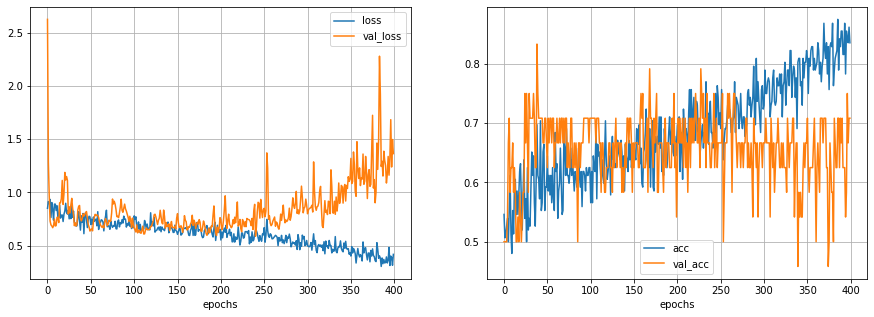

In [52]:
# lr = 1e-4

# plot training history
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'],label = "val_loss")
plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.subplot(1,2,2)
plt.plot(history.history['acc'], label = "acc")
plt.plot(history.history['val_acc'],label = "val_acc")
plt.xlabel('epochs')
plt.legend()
plt.grid()
plt.show()

## Complex Intercept, Linear shift (CIB-LSx)

In [208]:
folder_name = "CIb_LSx/"
C = 2
## create folders: run only once
#os.mkdir(OUTPUT_DIR + folder_name)
#for i in range(5):
#    os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i))
#    for j in range(5):
#        os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i) + "/run" + str(j))

In [209]:
# Hyperparameters
batch_size = 8
epochs = 200

In [210]:
# function for preprocessing
def train_preprocessing(data, label):
    """Process training data."""
    volume = data[0] # complex intercept: image
    tabular = data[1] # shift: tabular
    volume = zoom(volume)
    volume = rotate(volume)
    volume = shift(volume)
    volume = flip(volume)
    return (volume, tabular), label

In [ ]:
j = 0
my_seed = 1
nll = np.empty((5, 1))
estimates = np.empty((5, 12)) # 12 variables
estimates_sd = np.empty((5, 12)) # 12 variables

for f in range(len(train_idxes)):
    
    train_idx = train_idxes[f]
    test_idx = test_idxes[f]
    valid_idx = valid_idxes[f]
    
    # Load data for fold j ------------------------------------------------------
    
    # define datasets
    X_tab_train = np.array([train[f].age, train[f].sex, train[f].antikoagulation_pre_stroke,
                            train[f].atrial_fibrillation, train[f].nihss_bl, train[f].sys_bloodpressure_bl, 
                            train[f].rf_diabetes, train[f].rf_hypertonia, train[f].rf_smoker, 
                            train[f].rf_tia_stroke, train[f].lyse, train[f].time_to_groin_puncture]).T
    X_tab_valid = np.array([valid[f].age, valid[f].sex, valid[f].antikoagulation_pre_stroke,
                            valid[f].atrial_fibrillation, valid[f].nihss_bl, valid[f].sys_bloodpressure_bl, 
                            valid[f].rf_diabetes, valid[f].rf_hypertonia, valid[f].rf_smoker, 
                            valid[f].rf_tia_stroke, valid[f].lyse, valid[f].time_to_groin_puncture]).T
    X_tab_test = np.array([test[f].age, test[f].sex, test[f].antikoagulation_pre_stroke,
                            test[f].atrial_fibrillation, test[f].nihss_bl, test[f].sys_bloodpressure_bl, 
                            test[f].rf_diabetes, test[f].rf_hypertonia, test[f].rf_smoker, 
                            test[f].rf_tia_stroke, test[f].lyse, test[f].time_to_groin_puncture]).T
    # normalize
    sd = np.empty((12,))
    for i in range(X_tab_train.shape[1]):
        train_mean = np.mean(X_tab_train[:,i])
        train_std = np.std(X_tab_train[:,i])
        X_tab_train[:,i] = (X_tab_train[:,i] - train_mean) / train_std
        X_tab_valid[:,i] = (X_tab_valid[:,i] - train_mean) / train_std
        X_tab_test[:,i] = (X_tab_test[:,i] - train_mean) / train_std
        sd[i] = train_std
    
    X_train = X[train_idx-1]
    X_valid = X[valid_idx-1]
    X_test = X[test_idx-1]
    
    Y_train = Y_cat[train_idx-1]
    Y_valid = Y_cat[valid_idx-1]
    Y_test = Y_cat[test_idx-1]
    
    dat_train = train[f]
    dat_valid = valid[f]
    dat_test = test[f]
    
    dat_train.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(j) + "/" + "dat_train.csv", index = False)
    dat_valid.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(j) + "/" + "dat_valid.csv", index = False)
    dat_test.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(j) + "/" + "dat_test.csv", index = False)  
    
    
    # Define datasets for ONTRAM ------------------------------------------------------
    
    train_data = tf.data.Dataset.from_tensor_slices((X_train, X_tab_train))
    train_labels = tf.data.Dataset.from_tensor_slices((Y_train))
    
    valid_data = tf.data.Dataset.from_tensor_slices((X_valid, X_tab_valid))
    valid_labels = tf.data.Dataset.from_tensor_slices((Y_valid))
    
    test_data = tf.data.Dataset.from_tensor_slices((X_test, X_tab_test))
    test_labels = tf.data.Dataset.from_tensor_slices((Y_test))
    
    train_loader = tf.data.Dataset.zip((train_data, train_labels))
    validation_loader = tf.data.Dataset.zip((valid_data, valid_labels))
    test_loader = tf.data.Dataset.zip((test_data, test_labels))
    
    train_dataset = (train_loader.shuffle(len(X_train))
                     .map(train_preprocessing)
                     .batch(batch_size, drop_remainder = True))
    validation_dataset = (validation_loader.batch(batch_size, drop_remainder = True))
    test_dataset = (test_loader.batch(len(X_test), drop_remainder = True))

    # Training ---------------------------------------------------------------------
    
    for i in range(5):

        # define model 
        mls = mod_linear_shift(X_tab_train.shape[1])
        mcs = img_model_3D(X_train.shape[1:], 1, 'im_in', 'linear')
    
        model = ontram(mcs, mls)
        
        # load weights (betas) from SI_LSx fold 4
        estims = pd.read_csv(OUTPUT_DIR + "SI_LSx/" + "fold" + str(4) + "/" + "estimates.csv")
        betas = estims.iloc[:, 1:].mean()
        betas = betas.values.reshape(12,1)
        for submod in model.mod_shift:
            submod.get_layer("lastlayer_LSx").set_weights([betas])
        
        # save weights of the best model
        checkpoint_filepath = OUTPUT_DIR + folder_name + "fold" + str(j) + "/" + "run" + str(i) + "/"
        
        checkpoint_cb = keras.callbacks.ModelCheckpoint(
            filepath = checkpoint_filepath + "model_weights.hdf5",
            save_weights_only = True,
            monitor = "val_loss",
            mode = 'min',
            save_best_only = True)
        
        early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=90, restore_best_weights=True)
    
        callbacks_list = [checkpoint_cb, early_stopping_cb]
        
        # compile and train
        
        model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-4),
                    loss = ontram_loss(C, batch_size),
                    metrics = [ontram_acc(C, batch_size)])
        history = model.fit(train_dataset,
                            validation_data = validation_dataset,
                            epochs = epochs,
                            shuffle = True,
                            verbose = 2,
                            callbacks = callbacks_list)
        
        # save the history
        pd.DataFrame(history.history).to_csv(checkpoint_filepath + "history.csv", index = False)
        
        # Do predictions
        #model.load_weights(checkpoint_filepath)
        test_batch_size = len(X_test)
        model.compile(loss = ontram_loss(C, test_batch_size))
        preds = predict_ontram(model, data = test_dataset)
        params = get_parameters(model)
        
        # save predictions/parameters
        cdf = pd.DataFrame(preds["cdf"])
        cdf.columns = ["y_pred" + str(i) for i in range(C+1)]
        cdf["p_id"] = dat_test.p_id.values
        cdf["y_true"] = np.argmax(Y_test, axis=1)
        cdf.to_csv(checkpoint_filepath + "cdf.csv", index = False)  
        
        pdf = pd.DataFrame(preds["pdf"])
        pdf.columns = ["y_pred" + str(i) for i in range(C)]
        pdf["p_id"] = dat_test.p_id.values
        pdf["y_true"] = np.argmax(Y_test, axis=1)
        pdf.to_csv(checkpoint_filepath + "pdf.csv", index = False)
        
        nll[i] = preds["nll"]
        estimates[i] = np.concatenate(params["shift"][0][0][0]) 
        estimates_sd[i] = np.concatenate(params["shift"][0][0][0])/sd 
    
    pd.DataFrame(nll).to_csv(OUTPUT_DIR + folder_name + "/fold" + str(j) + "/nll.csv", index = False)
    
    pd_estimates = pd.DataFrame(estimates)
    pd_estimates.columns = ["age", "sex", "antikoagulation_pre_stroke",
                            "atrial_fibrillation", "nihss_bl", "sys_bloodpressure_bl", "rf_diabetes", 
                            "rf_hypertonia", "rf_smoker", "rf_tia_stroke", "lyse", "time_to_groin_puncture"]
    pd_estimates.to_csv(OUTPUT_DIR + folder_name + "/fold" + str(j) + "/estimates.csv", index = False)
    pd_estimates_sd = pd.DataFrame(estimates_sd)
    pd_estimates_sd.columns = ["age", "sex", "antikoagulation_pre_stroke",
                               "atrial_fibrillation", "nihss_bl", "sys_bloodpressure_bl", "rf_diabetes", 
                               "rf_hypertonia", "rf_smoker", "rf_tia_stroke", "lyse", "time_to_groin_puncture"]
    pd_estimates_sd.to_csv(OUTPUT_DIR + folder_name + "fold" + str(j) + "/estimates_sd.csv", index = False)
    
    j += 1

Epoch 1/200
19/19 - 39s - loss: 0.4345 - acc: 0.7895 - val_loss: 0.8024 - val_acc: 0.6667
Epoch 2/200
19/19 - 38s - loss: 0.3237 - acc: 0.8750 - val_loss: 0.3364 - val_acc: 0.8750
Epoch 3/200
19/19 - 39s - loss: 0.3413 - acc: 0.8421 - val_loss: 0.3122 - val_acc: 0.9583
Epoch 4/200


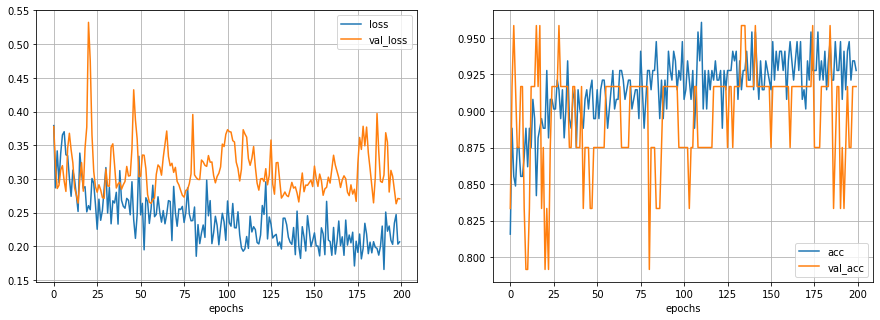

In [203]:
# plot training history lr=1e-4
folder_name = "CIb_LSx/"
checkpoint_filepath = OUTPUT_DIR + folder_name + "fold" + str(0) + "/" + "run" + str(0) + "/"
history = pd.read_csv(checkpoint_filepath + "history.csv")


plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(history['loss'], label = "loss")
plt.plot(history['val_loss'],label = "val_loss")
plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.subplot(1,2,2)
plt.plot(history['acc'], label = "acc")
plt.plot(history['val_acc'],label = "val_acc")
plt.xlabel('epochs')
plt.legend()
plt.grid()
plt.show()

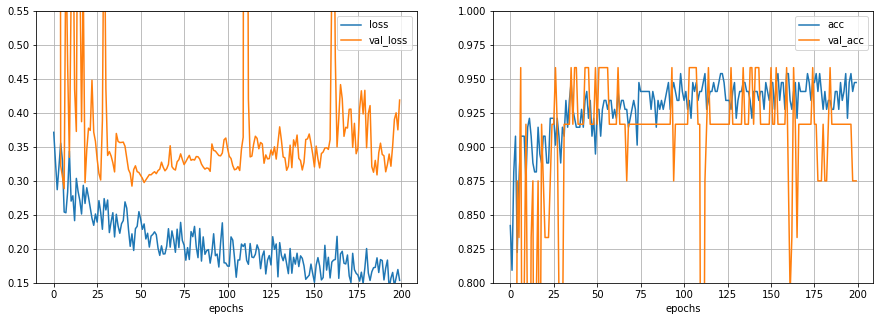

In [207]:
# plot training history lr=5*1e-4
folder_name = "CIb_LSx/"
checkpoint_filepath = OUTPUT_DIR + folder_name + "fold" + str(0) + "/" + "run" + str(0) + "/"
history = pd.read_csv(checkpoint_filepath + "history.csv")


plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(history['loss'], label = "loss")
plt.plot(history['val_loss'],label = "val_loss")
plt.ylim(0.15, 0.55)
plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.subplot(1,2,2)
plt.plot(history['acc'], label = "acc")
plt.plot(history['val_acc'],label = "val_acc")
plt.ylim(0.8, 1)
plt.xlabel('epochs')
plt.legend()
plt.grid()
plt.show()

## Simple intercept, Complex shift, Linear shift

In [81]:
folder_name = "SI_LSx_CSb/"
C = 2
## create folders: run only once
#os.mkdir(OUTPUT_DIR + folder_name)
#for i in range(5):
#    os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i))
#    for j in range(5):
#        os.mkdir(OUTPUT_DIR + folder_name + "fold" + str(i) + "/run" + str(j))

In [82]:
# Hyperparameters
batch_size = 8
epochs = 200

In [83]:
# function for preprocessing
def train_preprocessing(data, label):
    """Process training data."""
    intercept = data[0] # intercept
    volume = data[1] # shift: image
    tabular = data[2] # shift: tabular
    volume = zoom(volume)
    volume = rotate(volume)
    volume = shift(volume)
    volume = flip(volume)
    return (intercept, volume, tabular), label

In [ ]:
j = 0
my_seed = 1
nll = np.empty((5, 1))
estimates = np.empty((5, C-1+12)) # 1 intercept, 12 variables
estimates_sd = np.empty((5, C-1+12)) # 1 intercept, 12 variables

for f in range(len(train_idxes)):
    
    train_idx = train_idxes[f]
    test_idx = test_idxes[f]
    valid_idx = valid_idxes[f]
    
    # Load data for fold j ------------------------------------------------------
    
    # define datasets
    X_tab_train = np.array([train[f].age, train[f].sex, train[f].antikoagulation_pre_stroke,
                            train[f].atrial_fibrillation, train[f].nihss_bl, train[f].sys_bloodpressure_bl, 
                            train[f].rf_diabetes, train[f].rf_hypertonia, train[f].rf_smoker, 
                            train[f].rf_tia_stroke, train[f].lyse, train[f].time_to_groin_puncture]).T
    X_tab_valid = np.array([valid[f].age, valid[f].sex, valid[f].antikoagulation_pre_stroke,
                            valid[f].atrial_fibrillation, valid[f].nihss_bl, valid[f].sys_bloodpressure_bl, 
                            valid[f].rf_diabetes, valid[f].rf_hypertonia, valid[f].rf_smoker, 
                            valid[f].rf_tia_stroke, valid[f].lyse, valid[f].time_to_groin_puncture]).T
    X_tab_test = np.array([test[f].age, test[f].sex, test[f].antikoagulation_pre_stroke,
                            test[f].atrial_fibrillation, test[f].nihss_bl, test[f].sys_bloodpressure_bl, 
                            test[f].rf_diabetes, test[f].rf_hypertonia, test[f].rf_smoker, 
                            test[f].rf_tia_stroke, test[f].lyse, test[f].time_to_groin_puncture]).T
    # normalize
    sd = np.empty((12,))
    for i in range(X_tab_train.shape[1]):
        train_mean = np.mean(X_tab_train[:,i])
        train_std = np.std(X_tab_train[:,i])
        X_tab_train[:,i] = (X_tab_train[:,i] - train_mean) / train_std
        X_tab_valid[:,i] = (X_tab_valid[:,i] - train_mean) / train_std
        X_tab_test[:,i] = (X_tab_test[:,i] - train_mean) / train_std
        sd[i] = train_std
    
    X_train = X[train_idx-1]
    X_valid = X[valid_idx-1]
    X_test = X[test_idx-1]
    
    Y_train = Y_cat[train_idx-1]
    Y_valid = Y_cat[valid_idx-1]
    Y_test = Y_cat[test_idx-1]
    
    dat_train = train[f]
    dat_valid = valid[f]
    dat_test = test[f]
    
    dat_train.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(j) + "/" + "dat_train.csv", index = False)
    dat_valid.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(j) + "/" + "dat_valid.csv", index = False)
    dat_test.to_csv(OUTPUT_DIR +  folder_name + "fold" + str(j) + "/" + "dat_test.csv", index = False)  
    
    
    # Define datasets for ONTRAM ------------------------------------------------------
    
    train_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_train),1]), X_train, X_tab_train))
    train_labels = tf.data.Dataset.from_tensor_slices((Y_train))
    
    valid_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_valid),1]), X_valid, X_tab_valid))
    valid_labels = tf.data.Dataset.from_tensor_slices((Y_valid))
    
    test_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_test),1]), X_test, X_tab_test))
    test_labels = tf.data.Dataset.from_tensor_slices((Y_test))
    
    train_loader = tf.data.Dataset.zip((train_data, train_labels))
    validation_loader = tf.data.Dataset.zip((valid_data, valid_labels))
    test_loader = tf.data.Dataset.zip((test_data, test_labels))
    
    train_dataset = (train_loader.shuffle(len(X_train))
                     .map(train_preprocessing)
                     .batch(batch_size, drop_remainder = True))
    validation_dataset = (validation_loader.batch(batch_size, drop_remainder = True))
    test_dataset = (test_loader.batch(len(X_test), drop_remainder = True))

    # Training ---------------------------------------------------------------------
    
    for i in range(5):

        # define model and load weights from SI_LSx
        mbl = mod_baseline(C)
        mls = mod_linear_shift(X_tab_train.shape[1])
        mcs = img_model_3D(X_train.shape[1:], 1, 'im_in', 'linear')
    
        model = ontram(mbl, [mcs, mls])
        
        # save weights of the best model
        checkpoint_filepath = OUTPUT_DIR + folder_name + "fold" + str(j) + "/" + "run" + str(i) + "/"
        
        checkpoint_cb = keras.callbacks.ModelCheckpoint(
            filepath = checkpoint_filepath + "model_weights.hdf5",
            save_weights_only = True,
            monitor = "val_loss",
            mode = 'min',
            save_best_only = True)
        
        early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=80, restore_best_weights=True)
    
        callbacks_list = [checkpoint_cb, early_stopping_cb]
        
        # compile and train
        model.compile(optimizer = keras.optimizers.Adam(learning_rate=2*1e-4),
                    loss = ontram_loss(C, batch_size),
                    metrics = [ontram_acc(C, batch_size)])
        history = model.fit(train_dataset,
                            validation_data = validation_dataset,
                            epochs = epochs,
                            shuffle = True,
                            verbose = 2,
                            callbacks = callbacks_list)
        
        # save the history
        pd.DataFrame(history.history).to_csv(checkpoint_filepath + "history.csv", index = False)
        
        # Do predictions
        #model.load_weights(checkpoint_filepath)
        test_batch_size = len(X_test)
        model.compile(loss = ontram_loss(C, test_batch_size))
        preds = predict_ontram(model, data = test_dataset)
        params = get_parameters(model)
        
        # save predictions/parameters
        cdf = pd.DataFrame(preds["cdf"])
        cdf.columns = ["y_pred" + str(i) for i in range(C+1)]
        cdf["p_id"] = dat_test.p_id.values
        cdf["y_true"] = np.argmax(Y_test, axis=1)
        cdf.to_csv(checkpoint_filepath + "cdf.csv", index = False)  
        
        pdf = pd.DataFrame(preds["pdf"])
        pdf.columns = ["y_pred" + str(i) for i in range(C)]
        pdf["p_id"] = dat_test.p_id.values
        pdf["y_true"] = np.argmax(Y_test, axis=1)
        pdf.to_csv(checkpoint_filepath + "pdf.csv", index = False)
        
        nll[i] = preds["nll"]
        estimates[i] = np.concatenate((params["intercept"][0][0][0], np.concatenate(params["shift"][0][1][0]))) 
        estimates_sd[i] = np.concatenate((params["intercept"][0][0][0], np.concatenate(params["shift"][0][1][0])/sd)) 
    
    pd.DataFrame(nll).to_csv(OUTPUT_DIR + folder_name + "/fold" + str(j) + "/nll.csv", index = False)
    
    pd_estimates = pd.DataFrame(estimates)
    pd_estimates.columns = ["intercept0", "age", "sex", "antikoagulation_pre_stroke",
                            "atrial_fibrillation", "nihss_bl", "sys_bloodpressure_bl", "rf_diabetes", 
                            "rf_hypertonia", "rf_smoker", "rf_tia_stroke", "lyse", "time_to_groin_puncture"]
    pd_estimates.to_csv(OUTPUT_DIR + folder_name + "/fold" + str(j) + "/estimates.csv", index = False)
    pd_estimates_sd = pd.DataFrame(estimates_sd)
    pd_estimates_sd.columns = ["intercept0", "age", "sex", "antikoagulation_pre_stroke",
                               "atrial_fibrillation", "nihss_bl", "sys_bloodpressure_bl", "rf_diabetes", 
                               "rf_hypertonia", "rf_smoker", "rf_tia_stroke", "lyse", "time_to_groin_puncture"]
    pd_estimates_sd.to_csv(OUTPUT_DIR + folder_name + "fold" + str(j) + "/estimates_sd.csv", index = False)
    
    j += 1

Epoch 1/200
19/19 - 39s - loss: 1.3642 - acc: 0.4145 - val_loss: 3.0906 - val_acc: 0.5000
Epoch 2/200
19/19 - 39s - loss: 1.3708 - acc: 0.4013 - val_loss: 2.3211 - val_acc: 0.5000
Epoch 3/200
19/19 - 38s - loss: 1.2133 - acc: 0.4342 - val_loss: 2.5778 - val_acc: 0.5000
Epoch 4/200
19/19 - 38s - loss: 1.2500 - acc: 0.4276 - val_loss: 1.2258 - val_acc: 0.5000
Epoch 5/200
19/19 - 39s - loss: 1.2662 - acc: 0.3947 - val_loss: 0.9549 - val_acc: 0.5833
Epoch 6/200


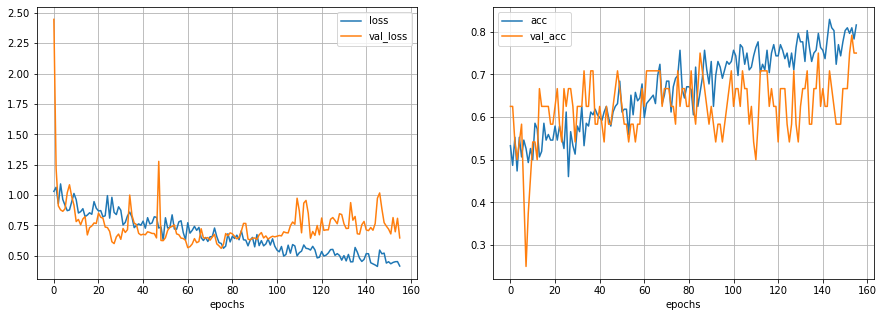

In [80]:
# plot training history
folder_name = "SI_LSx_CSb/"
checkpoint_filepath = OUTPUT_DIR + folder_name + "fold" + str(0) + "/" + "run" + str(0) + "/"
history = pd.read_csv(checkpoint_filepath + "history.csv")


plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(history['loss'], label = "loss")
plt.plot(history['val_loss'],label = "val_loss")
plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.subplot(1,2,2)
plt.plot(history['acc'], label = "acc")
plt.plot(history['val_acc'],label = "val_acc")
plt.xlabel('epochs')
plt.legend()
plt.grid()
plt.show()

## Save plots of training results

In [213]:
num_folds = 5
num_runs = 5
folder_name = "CIb_LSx/"


# Iterate through folds
for f in range(num_folds):
    # Create a new figure for each fold
    fig, axs = plt.subplots(num_runs, 2, figsize=(15, 5 * num_runs))

    # Iterate through runs for each fold
    for run in range(num_runs):
        cfp = OUTPUT_DIR + folder_name + "/" + "fold" + str(f) + "/" + "run" + str(run) + "/"
        hist = pd.read_csv(cfp + "history.csv")

        # Plot on the corresponding subplot
        axs[run, 0].plot(hist['loss'], label="nll")
        axs[run, 0].plot(hist['val_loss'], label="val_nll")
        axs[run, 0].legend()
        axs[run, 0].grid()
        axs[run, 0].set_xlabel('epochs')
        axs[run, 0].set_title(f"fold {f}, run {run}")

        axs[run, 1].plot(hist['acc'], label="acc")
        axs[run, 1].plot(hist['val_acc'], label="val_acc")
        axs[run, 1].set_xlabel('epochs')
        axs[run, 1].legend()
        axs[run, 1].grid()
        axs[run, 1].set_title(f"fold {f}, run {run}")

    # Adjust layout and save the figure for the current fold
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR + folder_name + "/" + "fold" + str(f) + "/" + "fold" + str(f) + "result_plots.pdf")
    plt.close()

# Trafo ensembles
Calculate the average CDF per patient by averaging the transformation functions

In [32]:
folder_names = ["CI", "SI_LSx", "CIb_LSx", "SI_LSx_CSb"]

In [33]:
for folder_name in folder_names:
    for f in range(5): # fold
        checkpoint_filepath = OUTPUT_DIR + folder_name + "/fold" + str(f) + "/"
        cdf0 = pd.read_csv(checkpoint_filepath + "run0/cdf.csv")
        cdf1 = pd.read_csv(checkpoint_filepath + "run1/cdf.csv")
        cdf2 = pd.read_csv(checkpoint_filepath + "run2/cdf.csv")
        cdf3 = pd.read_csv(checkpoint_filepath + "run3/cdf.csv")
        cdf4 = pd.read_csv(checkpoint_filepath + "run4/cdf.csv")
        cdf = pd.concat((cdf0[["y_pred0", "y_pred1", "y_pred2"]], 
                         cdf1[["y_pred0", "y_pred1", "y_pred2"]], 
                         cdf2[["y_pred0", "y_pred1", "y_pred2"]], 
                         cdf3[["y_pred0", "y_pred1", "y_pred2"]], 
                         cdf4[["y_pred0", "y_pred1", "y_pred2"]]))
        by_row_index = cdf.groupby(cdf.index)
        
        trafo_cdf = by_row_index.apply(lambda x: expit(np.mean(logit(x))))
        trafo_pdf = np.array(trafo_cdf)[:,1:] - np.array(trafo_cdf)[:,:-1]
        y_pred = np.argmax(trafo_pdf, axis = 1)
        y_true = cdf0.y_true
        
        y_pred_non_cardio = np.sum(trafo_pdf[:,:1], axis = 1) 
        y_pred_cardio = np.sum(trafo_pdf[:,1:], axis = 1)
        
    
        trafo_cdf["p_id"] = cdf0.p_id
        trafo_cdf["y_true"] = cdf0.y_true
        trafo_cdf["y_pred"] = y_pred
        trafo_cdf.to_csv(checkpoint_filepath + "/trafo_cdf.csv", index = False)
        
        trafo_pdf = pd.DataFrame(trafo_pdf)
        trafo_pdf.columns = ["y_pred" + str(i) for i in range(C)]
        trafo_pdf["p_id"] = cdf0.p_id
        trafo_pdf["y_true"] = cdf0.y_true 
        trafo_pdf["y_pred"] = y_pred
        trafo_pdf.to_csv(checkpoint_filepath + "/trafo_pdf.csv", index = False)
        
        trafo_pdf_bin = pd.DataFrame({"y_pred0_non_cardio": y_pred_non_cardio, 
                                      "y_pred1_cardio": y_pred_cardio,
                                      "y_pred": y_pred,
                                      "y_true": y_true,
                                      "p_id": cdf0.p_id})
        trafo_pdf_bin.to_csv(checkpoint_filepath + "/trafo_pdf_bin.csv", index = False)

In [34]:
# combine all test samples
for folder_name in folder_names:
    checkpoint_filepath = OUTPUT_DIR + folder_name 
    cdf0 = pd.read_csv(checkpoint_filepath + "/fold0/trafo_cdf.csv")
    cdf1 = pd.read_csv(checkpoint_filepath + "/fold1/trafo_cdf.csv")
    cdf2 = pd.read_csv(checkpoint_filepath + "/fold2/trafo_cdf.csv")
    cdf3 = pd.read_csv(checkpoint_filepath + "/fold3/trafo_cdf.csv")
    cdf4 = pd.read_csv(checkpoint_filepath + "/fold4/trafo_cdf.csv")
    cdf = pd.concat((cdf0, cdf1, cdf2, cdf3, cdf4))
    cdf.to_csv(OUTPUT_DIR + folder_name + "/test_cdf.csv", index = False)
    
    pdf0 = pd.read_csv(checkpoint_filepath + "/fold0/trafo_pdf.csv")
    pdf1 = pd.read_csv(checkpoint_filepath + "/fold1/trafo_pdf.csv")
    pdf2 = pd.read_csv(checkpoint_filepath + "/fold2/trafo_pdf.csv")
    pdf3 = pd.read_csv(checkpoint_filepath + "/fold3/trafo_pdf.csv")
    pdf4 = pd.read_csv(checkpoint_filepath + "/fold4/trafo_pdf.csv")
    pdf = pd.concat((pdf0, pdf1, pdf2, pdf3, pdf4))
    pdf.to_csv(OUTPUT_DIR + folder_name + "/test_pdf.csv", index = False)
    
    pdf_bin0 = pd.read_csv(checkpoint_filepath + "/fold0/trafo_pdf_bin.csv")
    pdf_bin1 = pd.read_csv(checkpoint_filepath + "/fold1/trafo_pdf_bin.csv")
    pdf_bin2 = pd.read_csv(checkpoint_filepath + "/fold2/trafo_pdf_bin.csv")
    pdf_bin3 = pd.read_csv(checkpoint_filepath + "/fold3/trafo_pdf_bin.csv")
    pdf_bin4 = pd.read_csv(checkpoint_filepath + "/fold4/trafo_pdf_bin.csv")
    pdf_bin = pd.concat((pdf_bin0, pdf_bin1, pdf_bin2, pdf_bin3, pdf_bin4))
    pdf_bin.to_csv(OUTPUT_DIR + folder_name + "/test_pdf_bin.csv", index = False)

In [35]:
nll = ["nll"]
acc = ["acc"]
qwk = ["qwk"]
bs = ["bs"]
auc = ["auc"]
for folder_name in folder_names:
    pdf = pd.read_csv(OUTPUT_DIR + folder_name + "/test_pdf.csv")
    
    nll.append(skm.log_loss(pdf.y_true, pdf[["y_pred0", "y_pred1"]]))
    acc.append(skm.accuracy_score(pdf.y_true, pdf.y_pred))
    qwk.append(skm.cohen_kappa_score(pdf.y_true, pdf.y_pred, labels = [0,1], weights = "quadratic"))
    bs.append(skm.brier_score_loss(y_true = pdf.y_true, y_prob = pdf.y_pred1, pos_label = 1))
    auc.append(skm.roc_auc_score(y_true = pdf.y_true, y_score = pdf.y_pred1))

# Results

In [36]:
# Binary stroke cause
header = [" ", "CI", "SI_LSx", "CI_LSx", "SI_LSx_CSb"]
data = [nll, acc, bs, auc]
print(tabulate(data, headers = header, tablefmt = "grid"))

+-----+----------+-----------+-----------+--------------+
|     |       CI |    SI_LSx |    CI_LSx |   SI_LSx_CSb |
+=====+==========+===========+===========+==============+
| nll | 0.63565  | 0.315954  | 0.257766  |     0.586306 |
+-----+----------+-----------+-----------+--------------+
| acc | 0.603604 | 0.896396  | 0.90991   |     0.684685 |
+-----+----------+-----------+-----------+--------------+
| bs  | 0.225235 | 0.0889234 | 0.0727963 |     0.200432 |
+-----+----------+-----------+-----------+--------------+
| auc | 0.672495 | 0.933938  | 0.953649  |     0.763216 |
+-----+----------+-----------+-----------+--------------+
